In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [13]:
dataset = pd.read_csv("C:\\Users\Maurice\\Documents\\QML\\CIC-IDS2017-MLCSV\\MachineLearningCVE\\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")


# Remove leading/trailing spaces from column names
dataset.columns = dataset.columns.str.strip()
# Replace infinities with NaN
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values with the mode (most frequent value) for categorical columns
dataset['Label'] = dataset['Label'].fillna(dataset['Label'].mode()[0])

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
dataset['Label'] = label_encoder.fit_transform(dataset['Label'])

# Verify that there are no missing values
print(dataset.isnull().sum())  # Should print 0 for all columns))
print("Sampled dataset size:", len(df1))

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64
Sampled dataset size: 2257


In [14]:
# Define sample size
n_samples = 500

# Select only numeric features
df_numeric = dataset.select_dtypes(include=['number'])

# Ensure there are at least 64 features
if df_numeric.shape[1] < 64:
    raise ValueError("Dataset has fewer than 64 numeric features. Consider feature engineering or PCA.")

# Randomly sample 200 rows while maintaining class balance
df_sampled = dataset.groupby('Label', group_keys=False).apply(lambda x: x.sample(min(len(x), n_samples // dataset['Label'].nunique()), random_state=42))

# Drop non-numeric columns (if any)
df_sampled = df_sampled.select_dtypes(include=['number']).reset_index(drop=True)

C:\Users\Maurice\AppData\Local\Temp\ipykernel_14844\2294693954.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = dataset.groupby('Label', group_keys=False).apply(lambda x: x.sample(min(len(x), n_samples // dataset['Label'].nunique()), random_state=42))


In [15]:
# Select the features (numeric columns) and labels
X = df_sampled.drop(columns=['Label'])

from sklearn.preprocessing import MinMaxScaler

X= pd.DataFrame(X, columns=X.columns)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Encode the labels as integers
y = df_sampled['Label'].factorize()[0]  # Converts the string labels to integer labels


# Check the shape of the data
print(X.shape, y.shape)

(500, 78) (500,)


In [16]:
from sklearn.decomposition import PCA

# Apply PCA if the dataset has more than 64 features
if X.shape[1] > 16:
    pca = PCA(n_components=16)
    X = pca.fit_transform(X)
    print(f"Reduced to {X.shape[1]} features using PCA")

# Otherwise, use the data as is
else:
    print(f"Dataset already has {X.shape[1]} features")


Reduced to 16 features using PCA


Training original model...

Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc
---------------------------------------------------------------------------
    0 | 0.2700 | 0.7874 | 0.0923 | 0.9155 | 0.0956 | 0.9127
    1 | 0.2287 | 0.8139 | 0.0956 | 0.9127 | 0.0978 | 0.9109
    2 | 0.1922 | 0.8388 | 0.0905 | 0.9170 | 0.0900 | 0.9175
    3 | 0.1613 | 0.8611 | 0.0831 | 0.9233 | 0.0882 | 0.9189
    4 | 0.1455 | 0.8730 | 0.0901 | 0.9174 | 0.0924 | 0.9154
    5 | 0.1339 | 0.8819 | 0.0931 | 0.9149 | 0.0954 | 0.9129
    6 | 0.1249 | 0.8889 | 0.0962 | 0.9122 | 0.1004 | 0.9087
    7 | 0.1173 | 0.8950 | 0.0994 | 0.9096 | 0.0978 | 0.9109
    8 | 0.1146 | 0.8971 | 0.1020 | 0.9075 | 0.0977 | 0.9110
    9 | 0.1117 | 0.8996 | 0.1040 | 0.9058 | 0.0986 | 0.9102
   10 | 0.1136 | 0.8980 | 0.1050 | 0.9050 | 0.1000 | 0.9091
   11 | 0.1113 | 0.8999 | 0.1060 | 0.9041 | 0.1018 | 0.9076
   12 | 0.1103 | 0.9006 | 0.1067 | 0.9036 | 0.1039 | 0.9059
   13 | 0.1080 | 0.902

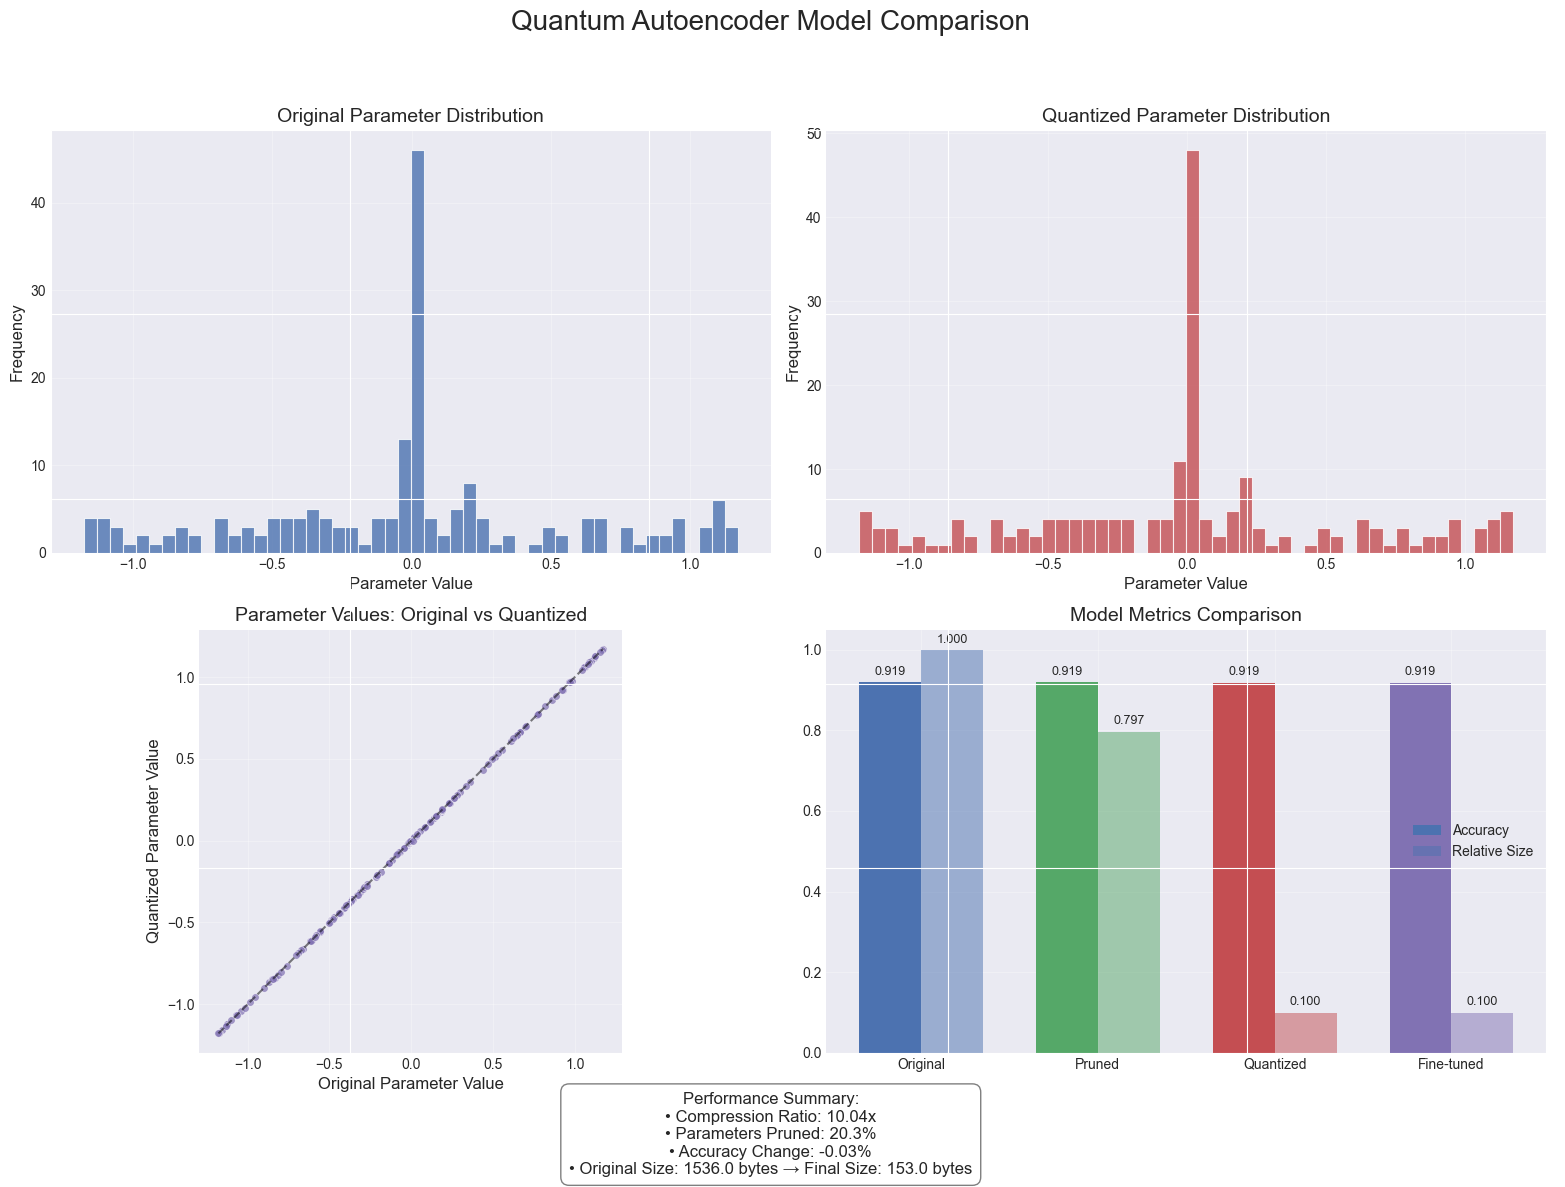

In [17]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class QuantumAutoencoder:
    def __init__(self, n_qubits, latent_qubits, depth=4, params=None):
        self.n_qubits = n_qubits
        self.latent_qubits = latent_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        self.n_params = self._calculate_params()
        if params is not None:
            self.params = params
        else:
            self.params = self._initialize_parameters()
        
        self.encoder = qml.QNode(self._encoder_circuit, self.dev, interface="torch")
        self.decoder = qml.QNode(self._decoder_circuit, self.dev, interface="torch")
        
        # Pruning mask (1 = keep, 0 = prune)
        self.pruning_mask = np.ones_like(self.params)
    
    def _calculate_params(self):
        """Calculate total number of parameters"""
        params_per_qubit = 6
        params_per_layer = self.n_qubits * params_per_qubit
        total_layers = 2 * self.depth
        return params_per_layer * total_layers
    
    def _initialize_parameters(self):
        """Improved parameter initialization"""
        params = np.zeros(self.n_params)
        # Xavier/Glorot initialization scaled to [0, 2π]
        scale = np.sqrt(2.0 / (self.n_qubits + self.latent_qubits)) * np.pi
        for i in range(self.n_params):
            params[i] = np.random.uniform(-scale, scale)
        return params

    def _encoder_circuit(self, data, params):
        """Enhanced encoder circuit with proper padding for 78 features"""
        # AmplitudeEmbedding handles the padding to 2^7 = 128 dimensions
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True, pad_with=0.0)
        
        param_idx = 0
        for d in range(self.depth):
            # More rotations per qubit
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Enhanced entanglement pattern
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def _decoder_circuit(self, latent_state, params):
        """Enhanced decoder circuit"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
            
        # Better initialization of non-latent qubits
        for i in range(self.latent_qubits, self.n_qubits):
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
            qml.RZ(np.pi/4, wires=i)
            
        param_idx = self.n_params // 2
        for d in range(self.depth):
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
                
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
                
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
            
        return qml.state()

    def get_latent_state(self, encoded_state):
        """Improved latent state extraction with proper numerical stability"""
        if torch.is_tensor(encoded_state):
            encoded_state = encoded_state.detach().numpy()
        
        # Ensure we're working with complex numbers
        encoded_state = encoded_state.astype(complex)
        
        # Create density matrix
        state_matrix = np.outer(encoded_state, np.conjugate(encoded_state))
        
        # Extract reduced density matrix for latent space
        dim = 2**self.latent_qubits
        reduced_matrix = state_matrix[:dim, :dim]
        
        # Ensure matrix is Hermitian before eigendecomposition
        reduced_matrix = (reduced_matrix + reduced_matrix.conj().T) / 2
        
        # Perform eigendecomposition with stability checks
        eigenvals, eigenvecs = np.linalg.eigh(reduced_matrix)
        
        # Filter out negative or very small eigenvalues
        eigenvals = np.maximum(eigenvals, 0)  # Set negative values to zero
        total = np.sum(eigenvals)
        if total < 1e-10:
            # If all eigenvalues are effectively zero, return a default state
            latent_state = np.zeros(dim, dtype=complex)
            latent_state[0] = 1.0  # Set to |0⟩ state
            return latent_state
        
        # Normalize eigenvalues
        eigenvals = eigenvals / total
        
        # Use top eigenvector with proper checks
        top_idx = np.argmax(eigenvals)
        latent_state = eigenvecs[:, top_idx]
        
        # Ensure proper normalization with phase correction
        norm = np.linalg.norm(latent_state)
        if norm < 1e-10:
            latent_state = np.zeros(dim, dtype=complex)
            latent_state[0] = 1.0
        else:
            # Normalize and fix global phase to have positive first element
            latent_state = latent_state / norm
            phase = np.angle(latent_state[0])
            latent_state = latent_state * np.exp(-1j * phase)
        
        return latent_state

        
    def forward(self, x):
        """Forward pass with proper tensor type handling"""
        # Convert input to numpy array if it's a tensor
        if torch.is_tensor(x):
            x_np = x.detach().numpy()
        else:
            x_np = x
            
        # Process through encoder
        encoded = self.encoder(x_np, self.params)
        
        # Get latent representation
        latent = self.get_latent_state(encoded)
        
        # Process through decoder
        decoded = self.decoder(latent, self.params)
        
        # Return result in the same format as the input
        if torch.is_tensor(x):
            # Convert to PyTorch tensor preserving gradients
            if isinstance(decoded, np.ndarray):
                decoded_tensor = torch.tensor(decoded, dtype=torch.complex128)
            else:
                decoded_tensor = decoded
            return decoded_tensor
        else:
            return decoded
    
    def apply_pruning(self, threshold_percentile=20):
        """
        Prune parameters with absolute values below a threshold percentile
        Returns the percentage of parameters pruned
        """
        abs_params = np.abs(self.params)
        threshold = np.percentile(abs_params, threshold_percentile)
        self.pruning_mask = np.where(abs_params > threshold, 1, 0)
        pruned_count = np.sum(self.pruning_mask == 0)
        return (pruned_count / len(self.params)) * 100
    
    def apply_quantization(self, bits=8):
        """
        Quantize parameters to specified bit precision
        Returns the original and quantized parameters for comparison
        """
        original_params = self.params.copy()
        
        # Find min and max for scaling
        p_min, p_max = np.min(self.params), np.max(self.params)
        
        # Scale to [0, 2^bits - 1]
        scale = (2**bits - 1) / (p_max - p_min)
        
        # Quantize
        quantized_int = np.round((self.params - p_min) * scale)
        
        # Scale back to original range
        self.params = (quantized_int / scale) + p_min
        
        # Apply pruning mask to ensure quantized pruned values stay at zero
        self.params = self.params * self.pruning_mask
        
        return original_params, self.params

def preprocess_data(X):
    """Enhanced data preprocessing specifically for 78 features mapped to 7 qubits (128 dimensions)"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalize each sample to have unit norm
    X_normalized = X_scaled / np.sqrt(np.sum(X_scaled**2, axis=1))[:, np.newaxis]
    
    # For amplitude encoding with 7 qubits (128 dimensions), padding will be handled by PennyLane
    # but we need to ensure our data is properly prepared
    return X_normalized

def evaluate_model(model, X_test):
    """Evaluate model on test data and return accuracy"""
    losses = []
    with torch.no_grad():
        for x in X_test:
            decoded = model.forward(x)
            decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
            loss = np.mean((decoded[:len(x)] - x)**2)
            losses.append(loss)
    
    test_loss = np.mean(losses)
    test_accuracy = 1 / (1 + test_loss)
    return test_loss, test_accuracy

def train_model(X, n_epochs=100, batch_size=4, learning_rate=0.002, seed=42):
    """Enhanced training process for quantum autoencoder"""
    set_seeds(seed)
    
    # Use the provided X dataset
    # Split data into train, validation, and test sets
    X_train, X_temp = train_test_split(X, test_size=0.3, random_state=seed)
    X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=seed)  # 15%/15% val/test split
    
    # Preprocess each dataset
    X_train = preprocess_data(X_train)
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)
    
    # For 78 features, we need 7 qubits (2^6 = 64 < 78 < 2^7 = 128)
    n_qubits = 4
    latent_qubits = 2  # Reduced dimensionality
    
    model = QuantumAutoencoder(n_qubits=n_qubits, latent_qubits=latent_qubits)
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=learning_rate)
    
    best_accuracy = 0.0
    best_params = None
    patience = 10
    patience_counter = 0
    
    metrics = {'train_losses': [], 'train_accuracies': [], 
              'val_losses': [], 'val_accuracies': [], 'test_losses':[], 'test_accuracies': []}
    
    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc")
    print("-" * 75)
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = max(1, len(X_train) // batch_size)
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), min(batch_size, len(X_train)))
            batch_data = X_train[batch_idx]
            
            # Initialize batch loss properly for accumulation
            batch_loss = 0.0
            
            for x in batch_data:
                # Convert input to tensor
                x_tensor = torch.tensor(x, dtype=torch.float64)
                
                # Forward pass
                decoded = model.forward(x)
                
                # Ensure decoded is a tensor with proper type
                if not torch.is_tensor(decoded):
                    decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)
                elif decoded.dtype != torch.float64:
                    decoded = decoded.real.to(torch.float64)
                
                # Calculate individual sample loss
                # Only compare against original dimensions
                reconstruction_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
                
                # Accumulate loss (without requiring grad)
                batch_loss += reconstruction_loss.item()
            
            # Calculate average reconstruction loss for the batch
            avg_recon_loss = batch_loss / len(batch_data)
            
            # Add L2 regularization directly to the final loss calculation
            final_loss = torch.tensor(avg_recon_loss, requires_grad=True) + 0.001 * torch.sum(params**2)
            
            # Backward pass on the properly constructed loss
            final_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            
            # Optimizer step
            optimizer.step()
            
            # Record loss for this batch
            epoch_loss += final_loss.item()
        
        train_loss = epoch_loss / n_batches
        train_accuracy = 1 / (1 + train_loss)
        
        # Validation
        val_losses = []
        with torch.no_grad():
            for x in X_val:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded[:len(x)] - x)**2)
                val_losses.append(val_loss)
        
        # Evaluate on test set
        test_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                test_loss = np.mean((decoded[:len(x)] - x)**2)
                test_losses.append(test_loss)

        test_loss = np.mean(test_losses)
        test_accuracy = 1 / (1 + test_loss)
        val_loss = np.mean(val_losses)
        val_accuracy = 1 / (1 + val_loss)

        metrics['test_losses'].append(test_loss)
        metrics['test_accuracies'].append(test_accuracy)
        metrics['train_losses'].append(train_loss)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_accuracy)
        
        print(f"{epoch:5d} | {train_loss:.4f} | {train_accuracy:.4f} | {val_loss:.4f} | {val_accuracy:.4f} | {test_loss:.4f} | {test_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
        
        if val_accuracy >= 0.998 and train_accuracy >= 0.998:
            print("\nTarget accuracy achieved!")
            break
    
    model.params = best_params.numpy()
    return model, best_accuracy, metrics, X_test

def compare_models(X, seed=42):
    """Train and compare original, pruned, and quantized models"""
    set_seeds(seed)
    
    # # Create synthetic dataset if needed
    # if X is None:
    #     X, _ = make_classification(n_samples=200, n_features=78, random_state=seed)
    
    # Train original model
    print("Training original model...")
    original_model, _, _, X_test = train_model(X, n_epochs=50, seed=seed)
    
    # Evaluate original model
    print("\nEvaluating original model...")
    original_loss, original_accuracy = evaluate_model(original_model, X_test)
    
    # Create pruned model (clone from original)
    print("\nApplying pruning...")
    pruned_model = QuantumAutoencoder(
        n_qubits=original_model.n_qubits,
        latent_qubits=original_model.latent_qubits,
        depth=original_model.depth,
        params=original_model.params.copy()
    )
    
    # Apply pruning (prune 20% of smallest magnitude parameters)
    pruning_percentage = pruned_model.apply_pruning(threshold_percentile=20)
    print(f"Pruned {pruning_percentage:.2f}% of parameters")
    
    # Evaluate pruned model
    pruned_loss, pruned_accuracy = evaluate_model(pruned_model, X_test)
    
    # Create quantized model (clone from pruned)
    print("\nApplying quantization...")
    quantized_model = QuantumAutoencoder(
        n_qubits=pruned_model.n_qubits,
        latent_qubits=pruned_model.latent_qubits,
        depth=pruned_model.depth,
        params=pruned_model.params.copy()
    )
    quantized_model.pruning_mask = pruned_model.pruning_mask.copy()
    
    # Apply 8-bit quantization
    original_params, quantized_params = quantized_model.apply_quantization(bits=8)
    
    # Evaluate quantized model
    quantized_loss, quantized_accuracy = evaluate_model(quantized_model, X_test)
    
    # Fine-tune quantized model
    print("\nFine-tuning quantized model...")
    # Convert params to tensor for fine-tuning
    params = torch.tensor(quantized_model.params, requires_grad=True)
    optimizer = Adam([params], lr=0.0005)  # Lower learning rate for fine-tuning
    
    # Preprocess data
    X_train, _ = train_test_split(X, test_size=0.3, random_state=seed)
    X_train = preprocess_data(X_train)
    
    # Fine-tuning loop (shorter)
    for epoch in range(20):
        # Apply params to model
        quantized_model.params = params.detach().numpy()
        
        # Batch processing
        batch_idx = np.random.choice(len(X_train), min(8, len(X_train)))
        batch_data = X_train[batch_idx]
        
        # Process batch
        optimizer.zero_grad()
        
        # Track loss as a tensor with gradients
        batch_loss = torch.tensor(0.0, dtype=torch.float64, requires_grad=True)
        
        for i, x in enumerate(batch_data):
            x_tensor = torch.tensor(x, dtype=torch.float64)
            
            # Set model parameters for this forward pass
            quantized_model.params = params.detach().numpy()
            
            # Forward pass
            decoded = quantized_model.forward(x)
            
            # Ensure decoded is a tensor with proper type
            if not torch.is_tensor(decoded):
                decoded = torch.tensor(np.real(decoded), dtype=torch.float64)
            elif decoded.dtype != torch.float64:
                decoded = decoded.real.to(torch.float64)
            
            # Calculate MSE loss with gradients attached
            if i == 0:
                # For the first sample, create a loss tensor with gradients
                batch_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
            else:
                # For subsequent samples, accumulate loss
                batch_loss = batch_loss + torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
        
        # Calculate average loss
        avg_loss = batch_loss / len(batch_data)
        
        # Add L2 regularization
        final_loss = avg_loss + 0.001 * torch.sum(params**2)
        
        # Backward and optimize
        final_loss.backward()
        optimizer.step()
        
        # Re-quantize after gradient update
        quantized_model.params = params.detach().numpy()
        _, quantized_model.params = quantized_model.apply_quantization(bits=8)
        params.data = torch.tensor(quantized_model.params)
        
        # Keep pruned parameters at zero
        quantized_model.params = quantized_model.params * quantized_model.pruning_mask
        params.data = torch.tensor(quantized_model.params)
        
        if (epoch + 1) % 5 == 0:
            try:
                print(f"Fine-tuning epoch {epoch+1}, Loss: {final_loss.item():.6f}")
            except:
                print(f"Fine-tuning epoch {epoch+1}, Loss calculation failed but training continues")
    
    # Final evaluation of fine-tuned quantized model
    finetuned_loss, finetuned_accuracy = evaluate_model(quantized_model, X_test)
    
    # Calculate compression metrics
    param_count = len(original_model.params)
    original_size = param_count * 64  # 64-bit floating point (8 bytes)
    pruned_size = np.sum(pruned_model.pruning_mask) * 64  # Only non-pruned params
    quantized_size = np.sum(quantized_model.pruning_mask) * 8  # 8-bit quantized non-pruned params
    compression_ratio = original_size / quantized_size
    
    # Print results
    print("\n" + "="*50)
    print("MODEL COMPARISON RESULTS")
    print("="*50)
    print(f"Original Model Accuracy:       {original_accuracy:.6f}")
    print(f"Pruned Model Accuracy:         {pruned_accuracy:.6f}")
    print(f"Quantized Model Accuracy:      {quantized_accuracy:.6f}")
    print(f"Fine-tuned Quantized Accuracy: {finetuned_accuracy:.6f}")
    print("-"*50)
    print(f"Original Size:        {original_size/8:.1f} bytes (100.0%)")
    print(f"After Pruning:        {pruned_size/8:.1f} bytes ({pruned_size/original_size*100:.1f}%)")
    print(f"After Quantization:   {quantized_size/8:.1f} bytes ({quantized_size/original_size*100:.1f}%)")
    print(f"Compression Ratio:    {compression_ratio:.2f}x")
    print(f"Accuracy Change:      {(finetuned_accuracy-original_accuracy)/original_accuracy*100:.2f}%")
    
    # Create enhanced visualizations with better styling
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Define a consistent color palette
    colors = {
        'original': '#4C72B0',      # Blue
        'pruned': '#55A868',        # Green
        'quantized': '#C44E52',     # Red
        'finetuned': '#8172B3'      # Purple
    }
    
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Quantum Autoencoder Model Comparison', fontsize=20, y=0.98)
    
    # Original parameters histogram
    ax1 = plt.subplot(2, 2, 1)
    n, bins, patches = ax1.hist(original_params.flatten(), bins=50, alpha=0.8, 
                               color=colors['original'], edgecolor='white', linewidth=0.8)
    ax1.set_title("Original Parameter Distribution", fontsize=14)
    ax1.set_xlabel("Parameter Value", fontsize=12)
    ax1.set_ylabel("Frequency", fontsize=12)
    ax1.grid(alpha=0.3)
    
    # Quantized parameters histogram
    ax2 = plt.subplot(2, 2, 2)
    n, bins, patches = ax2.hist(quantized_params.flatten(), bins=50, alpha=0.8,
                               color=colors['quantized'], edgecolor='white', linewidth=0.8)
    ax2.set_title("Quantized Parameter Distribution", fontsize=14)
    ax2.set_xlabel("Parameter Value", fontsize=12)
    ax2.set_ylabel("Frequency", fontsize=12)
    ax2.grid(alpha=0.3)
    
    # Highlight parameter changes with scatter plot
    ax3 = plt.subplot(2, 2, 3)
    
    # Only plot a subset of parameters (up to 1000 for visibility)
    max_params = min(1000, len(original_params))
    sample_indices = np.random.choice(len(original_params), max_params, replace=False)
    
    ax3.scatter(original_params.flatten()[sample_indices], 
                quantized_params.flatten()[sample_indices], 
                alpha=0.7, s=30, color=colors['finetuned'], edgecolor='white', linewidth=0.5)
    
    # Add diagonal line for reference
    min_val = min(original_params.min(), quantized_params.min())
    max_val = max(original_params.max(), quantized_params.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    ax3.set_title("Parameter Values: Original vs Quantized", fontsize=14)
    ax3.set_xlabel("Original Parameter Value", fontsize=12)
    ax3.set_ylabel("Quantized Parameter Value", fontsize=12)
    ax3.grid(alpha=0.3)
    ax3.set_aspect('equal')
    
    # Accuracy and size comparison as a grouped bar chart
    ax4 = plt.subplot(2, 2, 4)
    
    # Group bar data
    x = np.arange(4)  # four groups
    width = 0.35
    
    # First set of bars: Accuracy
    metrics = ["Original", "Pruned", "Quantized", "Fine-tuned"]
    accuracies = [original_accuracy, pruned_accuracy, quantized_accuracy, finetuned_accuracy]
    bars1 = ax4.bar(x - width/2, accuracies, width, label='Accuracy',
                   color=[colors['original'], colors['pruned'], colors['quantized'], colors['finetuned']])
    
    # Second set of bars: Relative Size (normalized)
    sizes = [1.0, pruned_size/original_size, quantized_size/original_size, quantized_size/original_size]  # Normalized to original
    bars2 = ax4.bar(x + width/2, sizes, width, label='Relative Size',
                   color=[colors['original'], colors['pruned'], colors['quantized'], colors['finetuned']], 
                   alpha=0.5)
    
    # Add labels and styling
    ax4.set_title("Model Metrics Comparison", fontsize=14)
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    # Add exact values on bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax4.annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=9)
    
    autolabel(bars1)
    autolabel(bars2)
    
    # Create a fifth subplot for additional metrics
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    # Add text summary of key metrics
    summary_text = (
        f"Performance Summary:\n"
        f"• Compression Ratio: {compression_ratio:.2f}x\n"
        f"• Parameters Pruned: {pruning_percentage:.1f}%\n"
        f"• Accuracy Change: {(finetuned_accuracy-original_accuracy)/original_accuracy*100:.2f}%\n"
        f"• Original Size: {original_size/8:.1f} bytes → Final Size: {quantized_size/8:.1f} bytes"
    )
    
    plt.figtext(0.5, 0.01, summary_text, ha="center", fontsize=12, 
                bbox={"facecolor":"white", "alpha":0.5, "pad":5, "boxstyle":"round,pad=0.5"})
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig("quantum_model_comparison.png", dpi=300, bbox_inches='tight')
    
    # Plot training history if metrics are available
    try:
        if isinstance(metrics, dict) and 'train_losses' in metrics:
            fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            fig2.suptitle('Quantum Autoencoder Training History', fontsize=18)
            
            epochs = range(len(metrics['train_losses']))
            
            # Plot losses
            ax1.plot(epochs, metrics['train_losses'], label='Train', color=colors['original'], linewidth=2)
            ax1.plot(epochs, metrics['val_losses'], label='Validation', color=colors['pruned'], linewidth=2)
            ax1.plot(epochs, metrics['test_losses'], label='Test', color=colors['quantized'], linewidth=2, linestyle='--')
            ax1.set_title('Loss During Training', fontsize=14)
            ax1.set_xlabel('Epochs', fontsize=12)
            ax1.set_ylabel('Loss', fontsize=12)
            ax1.legend()
            ax1.grid(alpha=0.3)
            
            # Plot accuracy
            ax2.plot(epochs, metrics['train_accuracies'], label='Train', color=colors['original'], linewidth=2)
            ax2.plot(epochs, metrics['val_accuracies'], label='Validation', color=colors['pruned'], linewidth=2)
            ax2.plot(epochs, metrics['test_accuracies'], label='Test', color=colors['quantized'], linewidth=2, linestyle='--')
            ax2.set_title('Accuracy During Training', fontsize=14)
            ax2.set_xlabel('Epochs', fontsize=12)
            ax2.set_ylabel('Accuracy', fontsize=12)
            ax2.legend()
            ax2.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.savefig("quantum_training_history.png", dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Could not plot training history: {e}")
    
    return {
        "original_accuracy": original_accuracy,
        "pruned_accuracy": pruned_accuracy, 
        "quantized_accuracy": quantized_accuracy,
        "finetuned_accuracy": finetuned_accuracy,
        "compression_ratio": compression_ratio,
        "pruning_percentage": pruning_percentage
    }

# # Generate synthetic data for testing if needed
# def generate_synthetic_data(n_samples=200, n_features=78, seed=42):
#     set_seeds(seed)
#     X, _ = make_classification(n_samples=n_samples, n_features=n_features, random_state=seed)
#     return X

if __name__ == "__main__":
    # To use synthetic data, uncomment this line:
    # X = generate_synthetic_data()
    
    # For real data, make sure X is defined
    # X = ...  # Your data with approx 78 features
    
    # Compare models and get results
    results = compare_models(X)
    
    # Print summary
    print("\nSUMMARY:")
    print(f"Original model accuracy: {results['original_accuracy']:.6f}")
    print(f"Final model accuracy: {results['finetuned_accuracy']:.6f}")
    print(f"Compression ratio: {results['compression_ratio']:.2f}x")
    print(f"Accuracy impact: {(results['finetuned_accuracy']-results['original_accuracy'])/results['original_accuracy']*100:.2f}%")

## TinyQL 4-Bits

Training original model...

Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc
---------------------------------------------------------------------------
    0 | 0.2700 | 0.7874 | 0.0923 | 0.9155 | 0.0956 | 0.9127
    1 | 0.2287 | 0.8139 | 0.0956 | 0.9127 | 0.0978 | 0.9109
    2 | 0.1922 | 0.8388 | 0.0905 | 0.9170 | 0.0900 | 0.9175
    3 | 0.1613 | 0.8611 | 0.0831 | 0.9233 | 0.0882 | 0.9189
    4 | 0.1455 | 0.8730 | 0.0901 | 0.9174 | 0.0924 | 0.9154
    5 | 0.1339 | 0.8819 | 0.0931 | 0.9149 | 0.0954 | 0.9129
    6 | 0.1249 | 0.8889 | 0.0962 | 0.9122 | 0.1004 | 0.9087
    7 | 0.1173 | 0.8950 | 0.0994 | 0.9096 | 0.0978 | 0.9109
    8 | 0.1146 | 0.8971 | 0.1020 | 0.9075 | 0.0977 | 0.9110
    9 | 0.1117 | 0.8996 | 0.1040 | 0.9058 | 0.0986 | 0.9102
   10 | 0.1136 | 0.8980 | 0.1050 | 0.9050 | 0.1000 | 0.9091
   11 | 0.1113 | 0.8999 | 0.1060 | 0.9041 | 0.1018 | 0.9076
   12 | 0.1103 | 0.9006 | 0.1067 | 0.9036 | 0.1039 | 0.9059
   13 | 0.1080 | 0.902

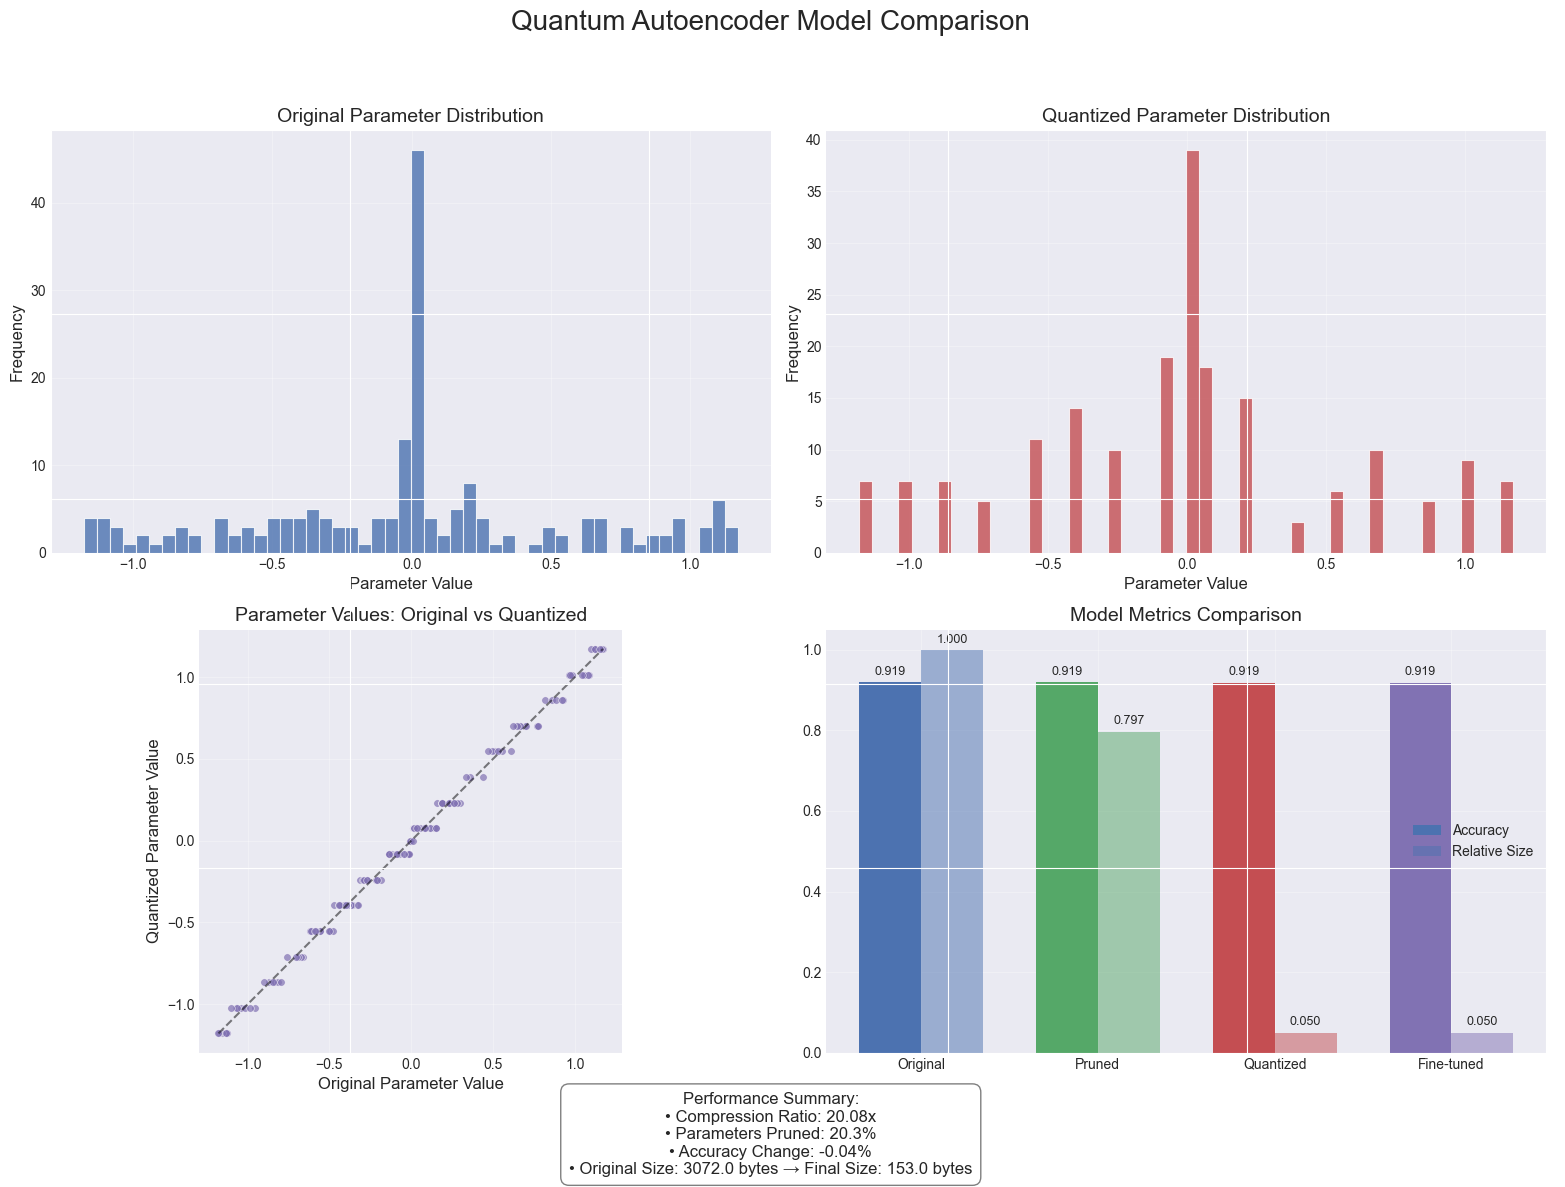

In [18]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class QuantumAutoencoder:
    def __init__(self, n_qubits, latent_qubits, depth=4, params=None):
        self.n_qubits = n_qubits
        self.latent_qubits = latent_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        self.n_params = self._calculate_params()
        if params is not None:
            self.params = params
        else:
            self.params = self._initialize_parameters()
        
        self.encoder = qml.QNode(self._encoder_circuit, self.dev, interface="torch")
        self.decoder = qml.QNode(self._decoder_circuit, self.dev, interface="torch")
        
        # Pruning mask (1 = keep, 0 = prune)
        self.pruning_mask = np.ones_like(self.params)
    
    def _calculate_params(self):
        """Calculate total number of parameters"""
        params_per_qubit = 6
        params_per_layer = self.n_qubits * params_per_qubit
        total_layers = 2 * self.depth
        return params_per_layer * total_layers
    
    def _initialize_parameters(self):
        """Improved parameter initialization"""
        params = np.zeros(self.n_params)
        # Xavier/Glorot initialization scaled to [0, 2π]
        scale = np.sqrt(2.0 / (self.n_qubits + self.latent_qubits)) * np.pi
        for i in range(self.n_params):
            params[i] = np.random.uniform(-scale, scale)
        return params

    def _encoder_circuit(self, data, params):
        """Enhanced encoder circuit with proper padding for 78 features"""
        # AmplitudeEmbedding handles the padding to 2^7 = 128 dimensions
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True, pad_with=0.0)
        
        param_idx = 0
        for d in range(self.depth):
            # More rotations per qubit
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Enhanced entanglement pattern
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def _decoder_circuit(self, latent_state, params):
        """Enhanced decoder circuit"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
            
        # Better initialization of non-latent qubits
        for i in range(self.latent_qubits, self.n_qubits):
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
            qml.RZ(np.pi/4, wires=i)
            
        param_idx = self.n_params // 2
        for d in range(self.depth):
            for i in range(self.n_qubits):
                qml.Rot(params[param_idx], params[param_idx + 1], 
                       params[param_idx + 2], wires=i)
                qml.RX(params[param_idx + 3], wires=i)
                qml.RY(params[param_idx + 4], wires=i)
                qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
                
            for i in range(self.n_qubits - 1):
                qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                qml.CNOT(wires=[i, i + 1])
                
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                    qml.CNOT(wires=[i, i + 2])
            
        return qml.state()

    def get_latent_state(self, encoded_state):
        """Improved latent state extraction with proper numerical stability"""
        if torch.is_tensor(encoded_state):
            encoded_state = encoded_state.detach().numpy()
        
        # Ensure we're working with complex numbers
        encoded_state = encoded_state.astype(complex)
        
        # Create density matrix
        state_matrix = np.outer(encoded_state, np.conjugate(encoded_state))
        
        # Extract reduced density matrix for latent space
        dim = 2**self.latent_qubits
        reduced_matrix = state_matrix[:dim, :dim]
        
        # Ensure matrix is Hermitian before eigendecomposition
        reduced_matrix = (reduced_matrix + reduced_matrix.conj().T) / 2
        
        # Perform eigendecomposition with stability checks
        eigenvals, eigenvecs = np.linalg.eigh(reduced_matrix)
        
        # Filter out negative or very small eigenvalues
        eigenvals = np.maximum(eigenvals, 0)  # Set negative values to zero
        total = np.sum(eigenvals)
        if total < 1e-10:
            # If all eigenvalues are effectively zero, return a default state
            latent_state = np.zeros(dim, dtype=complex)
            latent_state[0] = 1.0  # Set to |0⟩ state
            return latent_state
        
        # Normalize eigenvalues
        eigenvals = eigenvals / total
        
        # Use top eigenvector with proper checks
        top_idx = np.argmax(eigenvals)
        latent_state = eigenvecs[:, top_idx]
        
        # Ensure proper normalization with phase correction
        norm = np.linalg.norm(latent_state)
        if norm < 1e-10:
            latent_state = np.zeros(dim, dtype=complex)
            latent_state[0] = 1.0
        else:
            # Normalize and fix global phase to have positive first element
            latent_state = latent_state / norm
            phase = np.angle(latent_state[0])
            latent_state = latent_state * np.exp(-1j * phase)
        
        return latent_state

        
    def forward(self, x):
        """Forward pass with proper tensor type handling"""
        # Convert input to numpy array if it's a tensor
        if torch.is_tensor(x):
            x_np = x.detach().numpy()
        else:
            x_np = x
            
        # Process through encoder
        encoded = self.encoder(x_np, self.params)
        
        # Get latent representation
        latent = self.get_latent_state(encoded)
        
        # Process through decoder
        decoded = self.decoder(latent, self.params)
        
        # Return result in the same format as the input
        if torch.is_tensor(x):
            # Convert to PyTorch tensor preserving gradients
            if isinstance(decoded, np.ndarray):
                decoded_tensor = torch.tensor(decoded, dtype=torch.complex128)
            else:
                decoded_tensor = decoded
            return decoded_tensor
        else:
            return decoded
    
    def apply_pruning(self, threshold_percentile=20):
        """
        Prune parameters with absolute values below a threshold percentile
        Returns the percentage of parameters pruned
        """
        abs_params = np.abs(self.params)
        threshold = np.percentile(abs_params, threshold_percentile)
        self.pruning_mask = np.where(abs_params > threshold, 1, 0)
        pruned_count = np.sum(self.pruning_mask == 0)
        return (pruned_count / len(self.params)) * 100
    
    def apply_quantization(self, bits=4):
        """
        Quantize parameters to specified bit precision
        Returns the original and quantized parameters for comparison
        """
        original_params = self.params.copy()
        
        # Find min and max for scaling
        p_min, p_max = np.min(self.params), np.max(self.params)
        
        # Scale to [0, 2^bits - 1]
        scale = (2**bits - 1) / (p_max - p_min)
        
        # Quantize
        quantized_int = np.round((self.params - p_min) * scale)
        
        # Scale back to original range
        self.params = (quantized_int / scale) + p_min
        
        # Apply pruning mask to ensure quantized pruned values stay at zero
        self.params = self.params * self.pruning_mask
        
        return original_params, self.params

def preprocess_data(X):
    """Enhanced data preprocessing specifically for 78 features mapped to 7 qubits (128 dimensions)"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalize each sample to have unit norm
    X_normalized = X_scaled / np.sqrt(np.sum(X_scaled**2, axis=1))[:, np.newaxis]
    
    # For amplitude encoding with 7 qubits (128 dimensions), padding will be handled by PennyLane
    # but we need to ensure our data is properly prepared
    return X_normalized

def evaluate_model(model, X_test):
    """Evaluate model on test data and return accuracy"""
    losses = []
    with torch.no_grad():
        for x in X_test:
            decoded = model.forward(x)
            decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
            loss = np.mean((decoded[:len(x)] - x)**2)
            losses.append(loss)
    
    test_loss = np.mean(losses)
    test_accuracy = 1 / (1 + test_loss)
    return test_loss, test_accuracy

def train_model(X, n_epochs=100, batch_size=4, learning_rate=0.002, seed=42):
    """Enhanced training process for quantum autoencoder"""
    set_seeds(seed)
    
    # Use the provided X dataset
    # Split data into train, validation, and test sets
    X_train, X_temp = train_test_split(X, test_size=0.3, random_state=seed)
    X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=seed)  # 15%/15% val/test split
    
    # Preprocess each dataset
    X_train = preprocess_data(X_train)
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)
    
    # For 78 features, we need 7 qubits (2^6 = 64 < 78 < 2^7 = 128)
    n_qubits = 4
    latent_qubits = 2  # Reduced dimensionality
    
    model = QuantumAutoencoder(n_qubits=n_qubits, latent_qubits=latent_qubits)
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=learning_rate)
    
    best_accuracy = 0.0
    best_params = None
    patience = 10
    patience_counter = 0
    
    metrics = {'train_losses': [], 'train_accuracies': [], 
              'val_losses': [], 'val_accuracies': [], 'test_losses':[], 'test_accuracies': []}
    
    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Test Loss | Test Acc")
    print("-" * 75)
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = max(1, len(X_train) // batch_size)
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), min(batch_size, len(X_train)))
            batch_data = X_train[batch_idx]
            
            # Initialize batch loss properly for accumulation
            batch_loss = 0.0
            
            for x in batch_data:
                # Convert input to tensor
                x_tensor = torch.tensor(x, dtype=torch.float64)
                
                # Forward pass
                decoded = model.forward(x)
                
                # Ensure decoded is a tensor with proper type
                if not torch.is_tensor(decoded):
                    decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)
                elif decoded.dtype != torch.float64:
                    decoded = decoded.real.to(torch.float64)
                
                # Calculate individual sample loss
                # Only compare against original dimensions
                reconstruction_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
                
                # Accumulate loss (without requiring grad)
                batch_loss += reconstruction_loss.item()
            
            # Calculate average reconstruction loss for the batch
            avg_recon_loss = batch_loss / len(batch_data)
            
            # Add L2 regularization directly to the final loss calculation
            final_loss = torch.tensor(avg_recon_loss, requires_grad=True) + 0.001 * torch.sum(params**2)
            
            # Backward pass on the properly constructed loss
            final_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            
            # Optimizer step
            optimizer.step()
            
            # Record loss for this batch
            epoch_loss += final_loss.item()
        
        train_loss = epoch_loss / n_batches
        train_accuracy = 1 / (1 + train_loss)
        
        # Validation
        val_losses = []
        with torch.no_grad():
            for x in X_val:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded[:len(x)] - x)**2)
                val_losses.append(val_loss)
        
        # Evaluate on test set
        test_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                test_loss = np.mean((decoded[:len(x)] - x)**2)
                test_losses.append(test_loss)

        test_loss = np.mean(test_losses)
        test_accuracy = 1 / (1 + test_loss)
        val_loss = np.mean(val_losses)
        val_accuracy = 1 / (1 + val_loss)

        metrics['test_losses'].append(test_loss)
        metrics['test_accuracies'].append(test_accuracy)
        metrics['train_losses'].append(train_loss)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_accuracy)
        
        print(f"{epoch:5d} | {train_loss:.4f} | {train_accuracy:.4f} | {val_loss:.4f} | {val_accuracy:.4f} | {test_loss:.4f} | {test_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
        
        if val_accuracy >= 0.998 and train_accuracy >= 0.998:
            print("\nTarget accuracy achieved!")
            break
    
    model.params = best_params.numpy()
    return model, best_accuracy, metrics, X_test

def compare_models(X, seed=42):
    """Train and compare original, pruned, and quantized models"""
    set_seeds(seed)
    
    # # Create synthetic dataset if needed
    # if X is None:
    #     X, _ = make_classification(n_samples=200, n_features=78, random_state=seed)
    
    # Train original model
    print("Training original model...")
    original_model, _, _, X_test = train_model(X, n_epochs=50, seed=seed)
    
    # Evaluate original model
    print("\nEvaluating original model...")
    original_loss, original_accuracy = evaluate_model(original_model, X_test)
    
    # Create pruned model (clone from original)
    print("\nApplying pruning...")
    pruned_model = QuantumAutoencoder(
        n_qubits=original_model.n_qubits,
        latent_qubits=original_model.latent_qubits,
        depth=original_model.depth,
        params=original_model.params.copy()
    )
    
    # Apply pruning (prune 20% of smallest magnitude parameters)
    pruning_percentage = pruned_model.apply_pruning(threshold_percentile=20)
    print(f"Pruned {pruning_percentage:.2f}% of parameters")
    
    # Evaluate pruned model
    pruned_loss, pruned_accuracy = evaluate_model(pruned_model, X_test)
    
    # Create quantized model (clone from pruned)
    print("\nApplying quantization...")
    quantized_model = QuantumAutoencoder(
        n_qubits=pruned_model.n_qubits,
        latent_qubits=pruned_model.latent_qubits,
        depth=pruned_model.depth,
        params=pruned_model.params.copy()
    )
    quantized_model.pruning_mask = pruned_model.pruning_mask.copy()
    
    # Apply 8-bit quantization
    original_params, quantized_params = quantized_model.apply_quantization(bits=4)
    
    # Evaluate quantized model
    quantized_loss, quantized_accuracy = evaluate_model(quantized_model, X_test)
    
    # Fine-tune quantized model
    print("\nFine-tuning quantized model...")
    # Convert params to tensor for fine-tuning
    params = torch.tensor(quantized_model.params, requires_grad=True)
    optimizer = Adam([params], lr=0.0005)  # Lower learning rate for fine-tuning
    
    # Preprocess data
    X_train, _ = train_test_split(X, test_size=0.3, random_state=seed)
    X_train = preprocess_data(X_train)
    
    # Fine-tuning loop (shorter)
    for epoch in range(20):
        # Apply params to model
        quantized_model.params = params.detach().numpy()
        
        # Batch processing
        batch_idx = np.random.choice(len(X_train), min(8, len(X_train)))
        batch_data = X_train[batch_idx]
        
        # Process batch
        optimizer.zero_grad()
        
        # Track loss as a tensor with gradients
        batch_loss = torch.tensor(0.0, dtype=torch.float64, requires_grad=True)
        
        for i, x in enumerate(batch_data):
            x_tensor = torch.tensor(x, dtype=torch.float64)
            
            # Set model parameters for this forward pass
            quantized_model.params = params.detach().numpy()
            
            # Forward pass
            decoded = quantized_model.forward(x)
            
            # Ensure decoded is a tensor with proper type
            if not torch.is_tensor(decoded):
                decoded = torch.tensor(np.real(decoded), dtype=torch.float64)
            elif decoded.dtype != torch.float64:
                decoded = decoded.real.to(torch.float64)
            
            # Calculate MSE loss with gradients attached
            if i == 0:
                # For the first sample, create a loss tensor with gradients
                batch_loss = torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
            else:
                # For subsequent samples, accumulate loss
                batch_loss = batch_loss + torch.mean((decoded[:len(x_tensor)] - x_tensor)**2)
        
        # Calculate average loss
        avg_loss = batch_loss / len(batch_data)
        
        # Add L2 regularization
        final_loss = avg_loss + 0.001 * torch.sum(params**2)
        
        # Backward and optimize
        final_loss.backward()
        optimizer.step()
        
        # Re-quantize after gradient update
        quantized_model.params = params.detach().numpy()
        _, quantized_model.params = quantized_model.apply_quantization(bits=4)
        params.data = torch.tensor(quantized_model.params)
        
        # Keep pruned parameters at zero
        quantized_model.params = quantized_model.params * quantized_model.pruning_mask
        params.data = torch.tensor(quantized_model.params)
        
        if (epoch + 1) % 5 == 0:
            try:
                print(f"Fine-tuning epoch {epoch+1}, Loss: {final_loss.item():.6f}")
            except:
                print(f"Fine-tuning epoch {epoch+1}, Loss calculation failed but training continues")
    
    # Final evaluation of fine-tuned quantized model
    finetuned_loss, finetuned_accuracy = evaluate_model(quantized_model, X_test)
    
    # Calculate compression metrics
    param_count = len(original_model.params)
    original_size = param_count * 64  # 64-bit floating point (8 bytes)
    pruned_size = np.sum(pruned_model.pruning_mask) * 64  # Only non-pruned params
    quantized_size = np.sum(quantized_model.pruning_mask) * 4  # 8-bit quantized non-pruned params
    compression_ratio = original_size / quantized_size
    
    # Print results
    print("\n" + "="*50)
    print("MODEL COMPARISON RESULTS")
    print("="*50)
    print(f"Original Model Accuracy:       {original_accuracy:.6f}")
    print(f"Pruned Model Accuracy:         {pruned_accuracy:.6f}")
    print(f"Quantized Model Accuracy:      {quantized_accuracy:.6f}")
    print(f"Fine-tuned Quantized Accuracy: {finetuned_accuracy:.6f}")
    print("-"*50)
    print(f"Original Size:        {original_size/4:.1f} bytes (100.0%)")
    print(f"After Pruning:        {pruned_size/4:.1f} bytes ({pruned_size/original_size*100:.1f}%)")
    print(f"After Quantization:   {quantized_size/4:.1f} bytes ({quantized_size/original_size*100:.1f}%)")
    print(f"Compression Ratio:    {compression_ratio:.2f}x")
    print(f"Accuracy Change:      {(finetuned_accuracy-original_accuracy)/original_accuracy*100:.2f}%")
    
    # Create enhanced visualizations with better styling
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Define a consistent color palette
    colors = {
        'original': '#4C72B0',      # Blue
        'pruned': '#55A868',        # Green
        'quantized': '#C44E52',     # Red
        'finetuned': '#8172B3'      # Purple
    }
    
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Quantum Autoencoder Model Comparison', fontsize=20, y=0.98)
    
    # Original parameters histogram
    ax1 = plt.subplot(2, 2, 1)
    n, bins, patches = ax1.hist(original_params.flatten(), bins=50, alpha=0.8, 
                               color=colors['original'], edgecolor='white', linewidth=0.8)
    ax1.set_title("Original Parameter Distribution", fontsize=14)
    ax1.set_xlabel("Parameter Value", fontsize=12)
    ax1.set_ylabel("Frequency", fontsize=12)
    ax1.grid(alpha=0.3)
    
    # Quantized parameters histogram
    ax2 = plt.subplot(2, 2, 2)
    n, bins, patches = ax2.hist(quantized_params.flatten(), bins=50, alpha=0.8,
                               color=colors['quantized'], edgecolor='white', linewidth=0.8)
    ax2.set_title("Quantized Parameter Distribution", fontsize=14)
    ax2.set_xlabel("Parameter Value", fontsize=12)
    ax2.set_ylabel("Frequency", fontsize=12)
    ax2.grid(alpha=0.3)
    
    # Highlight parameter changes with scatter plot
    ax3 = plt.subplot(2, 2, 3)
    
    # Only plot a subset of parameters (up to 1000 for visibility)
    max_params = min(1000, len(original_params))
    sample_indices = np.random.choice(len(original_params), max_params, replace=False)
    
    ax3.scatter(original_params.flatten()[sample_indices], 
                quantized_params.flatten()[sample_indices], 
                alpha=0.7, s=30, color=colors['finetuned'], edgecolor='white', linewidth=0.5)
    
    # Add diagonal line for reference
    min_val = min(original_params.min(), quantized_params.min())
    max_val = max(original_params.max(), quantized_params.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    ax3.set_title("Parameter Values: Original vs Quantized", fontsize=14)
    ax3.set_xlabel("Original Parameter Value", fontsize=12)
    ax3.set_ylabel("Quantized Parameter Value", fontsize=12)
    ax3.grid(alpha=0.3)
    ax3.set_aspect('equal')
    
    # Accuracy and size comparison as a grouped bar chart
    ax4 = plt.subplot(2, 2, 4)
    
    # Group bar data
    x = np.arange(4)  # four groups
    width = 0.35
    
    # First set of bars: Accuracy
    metrics = ["Original", "Pruned", "Quantized", "Fine-tuned"]
    accuracies = [original_accuracy, pruned_accuracy, quantized_accuracy, finetuned_accuracy]
    bars1 = ax4.bar(x - width/2, accuracies, width, label='Accuracy',
                   color=[colors['original'], colors['pruned'], colors['quantized'], colors['finetuned']])
    
    # Second set of bars: Relative Size (normalized)
    sizes = [1.0, pruned_size/original_size, quantized_size/original_size, quantized_size/original_size]  # Normalized to original
    bars2 = ax4.bar(x + width/2, sizes, width, label='Relative Size',
                   color=[colors['original'], colors['pruned'], colors['quantized'], colors['finetuned']], 
                   alpha=0.5)
    
    # Add labels and styling
    ax4.set_title("Model Metrics Comparison", fontsize=14)
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    # Add exact values on bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax4.annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=9)
    
    autolabel(bars1)
    autolabel(bars2)
    
    # Create a fifth subplot for additional metrics
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    # Add text summary of key metrics
    summary_text = (
        f"Performance Summary:\n"
        f"• Compression Ratio: {compression_ratio:.2f}x\n"
        f"• Parameters Pruned: {pruning_percentage:.1f}%\n"
        f"• Accuracy Change: {(finetuned_accuracy-original_accuracy)/original_accuracy*100:.2f}%\n"
        f"• Original Size: {original_size/4:.1f} bytes → Final Size: {quantized_size/4:.1f} bytes"
    )
    
    plt.figtext(0.5, 0.01, summary_text, ha="center", fontsize=12, 
                bbox={"facecolor":"white", "alpha":0.5, "pad":5, "boxstyle":"round,pad=0.5"})
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig("quantum_model_comparison.png", dpi=300, bbox_inches='tight')
    
    # Plot training history if metrics are available
    try:
        if isinstance(metrics, dict) and 'train_losses' in metrics:
            fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            fig2.suptitle('Quantum Autoencoder Training History', fontsize=18)
            
            epochs = range(len(metrics['train_losses']))
            
            # Plot losses
            ax1.plot(epochs, metrics['train_losses'], label='Train', color=colors['original'], linewidth=2)
            ax1.plot(epochs, metrics['val_losses'], label='Validation', color=colors['pruned'], linewidth=2)
            ax1.plot(epochs, metrics['test_losses'], label='Test', color=colors['quantized'], linewidth=2, linestyle='--')
            ax1.set_title('Loss During Training', fontsize=14)
            ax1.set_xlabel('Epochs', fontsize=12)
            ax1.set_ylabel('Loss', fontsize=12)
            ax1.legend()
            ax1.grid(alpha=0.3)
            
            # Plot accuracy
            ax2.plot(epochs, metrics['train_accuracies'], label='Train', color=colors['original'], linewidth=2)
            ax2.plot(epochs, metrics['val_accuracies'], label='Validation', color=colors['pruned'], linewidth=2)
            ax2.plot(epochs, metrics['test_accuracies'], label='Test', color=colors['quantized'], linewidth=2, linestyle='--')
            ax2.set_title('Accuracy During Training', fontsize=14)
            ax2.set_xlabel('Epochs', fontsize=12)
            ax2.set_ylabel('Accuracy', fontsize=12)
            ax2.legend()
            ax2.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.savefig("quantum_training_history.png", dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Could not plot training history: {e}")
    
    return {
        "original_accuracy": original_accuracy,
        "pruned_accuracy": pruned_accuracy, 
        "quantized_accuracy": quantized_accuracy,
        "finetuned_accuracy": finetuned_accuracy,
        "compression_ratio": compression_ratio,
        "pruning_percentage": pruning_percentage
    }

# # Generate synthetic data for testing if needed
# def generate_synthetic_data(n_samples=200, n_features=78, seed=42):
#     set_seeds(seed)
#     X, _ = make_classification(n_samples=n_samples, n_features=n_features, random_state=seed)
#     return X

if __name__ == "__main__":
    # To use synthetic data, uncomment this line:
    # X = generate_synthetic_data()
    
    # For real data, make sure X is defined
    # X = ...  # Your data with approx 78 features
    
    # Compare models and get results
    results = compare_models(X)
    
    # Print summary
    print("\nSUMMARY:")
    print(f"Original model accuracy: {results['original_accuracy']:.6f}")
    print(f"Final model accuracy: {results['finetuned_accuracy']:.6f}")
    print(f"Compression ratio: {results['compression_ratio']:.2f}x")
    print(f"Accuracy impact: {(results['finetuned_accuracy']-results['original_accuracy'])/results['original_accuracy']*100:.2f}%")

## TinyQL 4-Bits

In [ ]:
import pennylane as qml
import numpy as np
import torch
import random
from torch.optim import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import psutil
import matplotlib.pyplot as plt

def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class QuantumAutoencoder:
    def __init__(self, n_qubits, latent_qubits, depth=4, pruned_params=None, quantized=False, bit_width=8):
        self.n_qubits = n_qubits
        self.latent_qubits = latent_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.quantized = quantized
        self.bit_width = bit_width
        self.pruned_params = pruned_params  # Dictionary of {param_idx: importance}
        
        self.n_params = self._calculate_params()
        self.params = self._initialize_parameters()
        
        self.encoder = qml.QNode(self._encoder_circuit, self.dev, interface="torch")
        self.decoder = qml.QNode(self._decoder_circuit, self.dev, interface="torch")
    
    def _calculate_params(self):
        """Calculate total number of parameters"""
        params_per_qubit = 6  # Increased parameters per qubit
        params_per_layer = self.n_qubits * params_per_qubit
        total_layers = 2 * self.depth
        return params_per_layer * total_layers
    
    def _initialize_parameters(self):
        """Improved parameter initialization"""
        params = np.zeros(self.n_params)
        # Xavier/Glorot initialization scaled to [0, 2π]
        scale = np.sqrt(2.0 / (self.n_qubits + self.latent_qubits)) * np.pi
        for i in range(self.n_params):
            params[i] = np.random.uniform(-scale, scale)
        return params
    
    def _encoder_circuit(self, data, params):
        """Enhanced encoder circuit with optional pruning"""
        qml.AmplitudeEmbedding(data, wires=range(self.n_qubits), normalize=True)
        
        param_idx = 0
        for d in range(self.depth):
            # More rotations per qubit
            for i in range(self.n_qubits):
                # Apply rotations only if not pruned or based on importance
                if self.pruned_params is None or param_idx in self.pruned_params:
                    qml.Rot(params[param_idx], params[param_idx + 1], 
                           params[param_idx + 2], wires=i)
                    qml.RX(params[param_idx + 3], wires=i)
                    qml.RY(params[param_idx + 4], wires=i)
                    qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            # Enhanced entanglement pattern - apply only if not pruned
            for i in range(self.n_qubits - 1):
                if self.pruned_params is None or param_idx % self.n_params in self.pruned_params:
                    qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                    qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    if self.pruned_params is None or (param_idx + 1) % self.n_params in self.pruned_params:
                        qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                        qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def _decoder_circuit(self, latent_state, params):
        """Enhanced decoder circuit with optional pruning"""
        qml.QubitStateVector(latent_state, wires=range(self.latent_qubits))
        
        # Better initialization of non-latent qubits
        for i in range(self.latent_qubits, self.n_qubits):
            qml.Hadamard(wires=i)
            qml.RY(np.pi/4, wires=i)
            qml.RZ(np.pi/4, wires=i)
        
        param_idx = self.n_params // 2
        for d in range(self.depth):
            for i in range(self.n_qubits):
                # Apply rotations only if not pruned or based on importance
                if self.pruned_params is None or param_idx in self.pruned_params:
                    qml.Rot(params[param_idx], params[param_idx + 1], 
                           params[param_idx + 2], wires=i)
                    qml.RX(params[param_idx + 3], wires=i)
                    qml.RY(params[param_idx + 4], wires=i)
                    qml.RZ(params[param_idx + 5], wires=i)
                param_idx += 6
            
            for i in range(self.n_qubits - 1):
                if self.pruned_params is None or param_idx % self.n_params in self.pruned_params:
                    qml.CRZ(params[param_idx % self.n_params], wires=[i, i + 1])
                    qml.CNOT(wires=[i, i + 1])
            
            if self.n_qubits > 2:
                for i in range(0, self.n_qubits - 2, 2):
                    if self.pruned_params is None or (param_idx + 1) % self.n_params in self.pruned_params:
                        qml.CRX(params[(param_idx + 1) % self.n_params], wires=[i, i + 2])
                        qml.CNOT(wires=[i, i + 2])
        
        return qml.state()
    
    def get_latent_state(self, encoded_state):
        """Improved latent state extraction"""
        if torch.is_tensor(encoded_state):
            encoded_state = encoded_state.detach().numpy()
        
        state_matrix = np.outer(encoded_state, np.conjugate(encoded_state))
        dim = 2**self.latent_qubits
        reduced_matrix = state_matrix[:dim, :dim]
        
        eigenvals, eigenvecs = np.linalg.eigh(reduced_matrix)
        # Use top 2 eigenvectors with proper weighting
        top_k = 2
        top_indices = np.argsort(eigenvals)[-top_k:]
        weights = eigenvals[top_indices] / np.sum(eigenvals[top_indices])
        latent_state = np.sum([w * eigenvecs[:, i] for w, i in zip(weights, top_indices)], axis=0)
        return latent_state / np.linalg.norm(latent_state)
    
    def forward(self, x):
        """Forward pass with optional quantization"""
        # Apply quantization to parameters if needed
        if self.quantized:
            quantized_params = self.quantize_parameters(self.params)
        else:
            quantized_params = self.params
            
        encoded = self.encoder(x, quantized_params)
        latent = self.get_latent_state(encoded)
        decoded = self.decoder(latent, quantized_params)
        return decoded
    
    def quantize_parameters(self, params):
        """Quantize parameters to a specified bit width"""
        if not self.quantized:
            return params
            
        # Define quantization range (typically [0, 2π] for quantum rotation angles)
        q_min, q_max = 0, 2 * np.pi
        
        # Calculate step size based on bit width
        steps = 2**self.bit_width - 1
        step_size = (q_max - q_min) / steps
        
        # Quantize parameters
        quantized = np.round((params - q_min) / step_size) * step_size + q_min
        
        # Clip to ensure we stay within bounds
        return np.clip(quantized, q_min, q_max)


def calculate_renyi_entropy(model, X_sample, alpha=2.0):
    """
    Calculate Rényi entropy for each parameter to determine importance.
    Higher entropy indicates more information contribution.
    
    Args:
        model: QuantumAutoencoder model
        X_sample: Sample data for entropy calculation
        alpha: Rényi entropy parameter (α=2 gives collision entropy)
    
    Returns:
        Dictionary mapping parameter indices to their entropy values
    """
    param_entropies = {}
    base_params = model.params.copy()
    n_params = len(base_params)
    n_samples = len(X_sample)
    
    # Small perturbation value
    epsilon = 0.1
    
    # Store original outputs for reference
    original_outputs = []
    for x in X_sample:
        output = model.forward(x)
        if torch.is_tensor(output):
            output = output.detach().numpy()
        original_outputs.append(output)
    
    # Calculate entropy for each parameter
    for idx in range(n_params):
        # Perturb the parameter
        perturbed_params = base_params.copy()
        perturbed_params[idx] += epsilon
        model.params = perturbed_params
        
        # Calculate output distributions
        distributions = []
        for i, x in enumerate(X_sample):
            output = model.forward(x)
            if torch.is_tensor(output):
                output = output.detach().numpy()
            
            # Calculate change in output compared to original
            delta = np.abs(output - original_outputs[i])
            # Normalize to get a probability distribution
            if np.sum(delta) > 0:
                delta = delta / np.sum(delta)
            distributions.append(delta)
        
        # Reset the parameters
        model.params = base_params
        
        # Calculate Rényi entropy for this parameter across all samples
        sample_entropies = []
        for dist in distributions:
            # Avoid log(0) issues
            prob_sum = np.sum(dist**alpha) + 1e-10
            entropy = (1 / (1 - alpha)) * np.log2(prob_sum)
            sample_entropies.append(entropy)
        
        # Average entropy across samples
        param_entropies[idx] = np.mean(sample_entropies)
    
    return param_entropies


def prune_model(model, X_sample, pruning_ratio=0.3, alpha=2.0):
    """
    Prune model parameters based on Rényi entropy.
    
    Args:
        model: QuantumAutoencoder model
        X_sample: Sample data for entropy calculation
        pruning_ratio: Fraction of parameters to keep (higher = more parameters kept)
        alpha: Rényi entropy parameter
    
    Returns:
        Pruned model
    """
    print(f"\nPerforming Rényi entropy-based pruning (keeping {pruning_ratio*100:.1f}% of parameters)...")
    
    # Calculate entropy for each parameter
    param_entropies = calculate_renyi_entropy(model, X_sample, alpha)
    
    # Sort parameters by entropy (importance)
    sorted_params = sorted(param_entropies.items(), key=lambda x: x[1], reverse=True)
    
    # Determine how many parameters to keep
    params_to_keep = int(len(model.params) * pruning_ratio)
    important_params = dict(sorted_params[:params_to_keep])
    
    print(f"Original parameters: {len(model.params)}")
    print(f"Parameters kept after pruning: {params_to_keep}")
    
    # Create a new model with pruned parameters
    pruned_model = QuantumAutoencoder(
        n_qubits=model.n_qubits,
        latent_qubits=model.latent_qubits,
        depth=model.depth,
        pruned_params=important_params
    )
    
    # Copy trained parameters
    pruned_model.params = model.params.copy()
    
    return pruned_model


def quantize_model(model, bit_width=8):
    """
    Quantize a model's parameters.
    
    Args:
        model: QuantumAutoencoder model
        bit_width: Bit width for quantization
    
    Returns:
        Quantized model
    """
    print(f"\nApplying {bit_width}-bit quantization...")
    
    # Create a new model with quantization enabled
    quantized_model = QuantumAutoencoder(
        n_qubits=model.n_qubits,
        latent_qubits=model.latent_qubits,
        depth=model.depth,
        pruned_params=model.pruned_params,
        quantized=True,
        bit_width=bit_width
    )
    
    # Copy trained parameters
    quantized_model.params = model.params.copy()
    
    return quantized_model


def preprocess_data(X):
    """Enhanced data preprocessing"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Additional normalization step
    X_scaled = X_scaled / np.max(np.abs(X_scaled))
    return X_scaled / np.sqrt(np.sum(X_scaled**2, axis=1))[:, np.newaxis]


def train_model(model, X_train, X_test, n_epochs=100, batch_size=4, learning_rate=0.002, seed=42):
    """Enhanced training process for a given model"""
    set_seeds(seed)
    
    start_time = time.time()
    start_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
    
    params = torch.tensor(model.params, requires_grad=True)
    optimizer = Adam([params], lr=learning_rate)
    
    best_accuracy = 0.0
    best_params = None
    patience = 10  # Increased patience
    patience_counter = 0
    
    metrics = {'train_losses': [], 'train_accuracies': [], 
              'val_losses': [], 'val_accuracies': []}
    
    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc")
    print("-" * 50)
    
    for epoch in range(n_epochs):
        model.params = params.detach().numpy()
        epoch_loss = 0
        n_batches = len(X_train) // batch_size
        
        for _ in range(n_batches):
            optimizer.zero_grad()
            batch_idx = np.random.choice(len(X_train), batch_size)
            batch_data = X_train[batch_idx]
            
            total_loss = torch.tensor(0.0, requires_grad=True)
            for x in batch_data:
                decoded = model.forward(x)
                if torch.is_tensor(decoded):
                    decoded = decoded.real
                decoded = torch.tensor(np.real(decoded), dtype=torch.float64, requires_grad=True)
                x_tensor = torch.tensor(x, dtype=torch.float32)
                
                # Enhanced loss calculation
                reconstruction_loss = torch.mean((decoded - x_tensor)**2)
                l2_reg = 0.0001 * torch.sum(params**2)  # Reduced L2 regularization
                loss = reconstruction_loss + l2_reg
                
                total_loss = total_loss + loss
            
            avg_loss = total_loss / batch_size
            avg_loss.backward()
            torch.nn.utils.clip_grad_norm_([params], max_norm=1.0)
            optimizer.step()
            epoch_loss += avg_loss.item()
        
        train_loss = epoch_loss / n_batches
        train_accuracy = 1 / (1 + train_loss)
        
        # Validation
        val_losses = []
        with torch.no_grad():
            for x in X_test:
                decoded = model.forward(x)
                decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
                val_loss = np.mean((decoded - x)**2)
                val_losses.append(val_loss)
        
        val_loss = np.mean(val_losses)
        val_accuracy = 1 / (1 + val_loss)
        
        metrics['train_losses'].append(train_loss)
        metrics['train_accuracies'].append(train_accuracy)
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_accuracy)
        
        print(f"{epoch:5d} | {train_loss:.4f} | {train_accuracy:.4f} | {val_loss:.4f} | {val_accuracy:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.detach().clone()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break
        
        if val_accuracy >= 0.95 and train_accuracy >= 0.95:
            print("\nTarget accuracy achieved!")
            break
    
    model.params = best_params.numpy()
    
    end_time = time.time()
    end_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
    
    training_stats = {
        'training_time': end_time - start_time,
        'memory_used': end_memory - start_memory,
        'best_accuracy': best_accuracy,
        'metrics': metrics,
        'final_train_accuracy': metrics['train_accuracies'][-1],
        'final_val_accuracy': metrics['val_accuracies'][-1],
    }
    
    return model, training_stats


def evaluate_model(model, X_test, iterations=50):
    """Evaluate model performance with memory and time metrics"""
    # Measure inference time
    start_time = time.time()
    start_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
    
    val_losses = []
    for _ in range(iterations):
        for x in X_test:
            decoded = model.forward(x)
            decoded = np.real(decoded) if not torch.is_tensor(decoded) else decoded.real.numpy()
            val_loss = np.mean((decoded - x)**2)
            val_losses.append(val_loss)
    
    end_time = time.time()
    end_memory = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
    
    avg_val_loss = np.mean(val_losses)
    accuracy = 1 / (1 + avg_val_loss)
    
    evaluation_stats = {
        'inference_time': (end_time - start_time) / (iterations * len(X_test)),  # Average time per sample
        'memory_used': end_memory - start_memory,
        'accuracy': accuracy,
    }
    
    return evaluation_stats


def plot_comparison(metrics_dict, title="Model Comparison"):
    """Plot comparison between original, pruned and quantized models"""
    categories = list(metrics_dict.keys())
    models = list(next(iter(metrics_dict.values())).keys())
    
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(2, len(categories)//2 + len(categories)%2, figsize=(15, 10))
    axes = axes.flatten()
    
    # Plot each metric
    for i, (metric, values) in enumerate(metrics_dict.items()):
        metric_values = [values[model] for model in models]
        axes[i].bar(models, metric_values)
        axes[i].set_title(metric)
        axes[i].set_ylabel(metric)
        axes[i].set_xticks(range(len(models)))
        axes[i].set_xticklabels(models, rotation=45)
    
    fig.suptitle(title, fontsize=16)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    # Return the figure for saving or displaying
    return fig


def run_optimization_comparison(n_epochs=50, batch_size=4, learning_rate=0.002, seed=42,
                               pruning_ratio=0.5, quantization_bits=8):
    """Run full optimization comparison workflow"""
    set_seeds(seed)
    
    # # Generate synthetic data
    # n_features = 16
    # X, y = make_classification(
    #     n_samples=200,
    #     n_features=n_features,
    #     n_classes=2,
    #     n_informative=6,
    #     n_redundant=0,
    #     n_clusters_per_class=2,
    #     class_sep=2.5,
    #     random_state=seed
    # )
    
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=seed)
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    
    n_qubits = int(np.log2(X_train.shape[1]))
    latent_qubits = n_qubits - 1
    
    results = {}
    
    # 1. Train and evaluate original model
    print("\n" + "="*50)
    print("Training Original Model")
    print("="*50)
    original_model = QuantumAutoencoder(n_qubits=n_qubits, latent_qubits=latent_qubits)
    original_model, original_training_stats = train_model(
        original_model, X_train, X_test, n_epochs=n_epochs, 
        batch_size=batch_size, learning_rate=learning_rate, seed=seed
    )
    
    original_eval_stats = evaluate_model(original_model, X_test)
    results['Original'] = {
        'model': original_model,
        'training_stats': original_training_stats,
        'eval_stats': original_eval_stats,
        'parameter_count': len(original_model.params),
    }
    
    # 2. Apply Rényi entropy-based pruning and evaluate
    print("\n" + "="*50)
    print("Applying Rényi Entropy-Based Pruning")
    print("="*50)
    # Use a subset of training data for entropy calculation
    entropy_sample = X_train[:min(len(X_train), 20)]
    pruned_model = prune_model(
        original_model, 
        entropy_sample, 
        pruning_ratio=pruning_ratio
    )
    
    # Fine-tune the pruned model with a few epochs
    print("\nFine-tuning Pruned Model")
    pruned_model, pruned_training_stats = train_model(
        pruned_model, X_train, X_test, n_epochs=max(5, n_epochs//5), 
        batch_size=batch_size, learning_rate=learning_rate/2, seed=seed
    )
    
    pruned_eval_stats = evaluate_model(pruned_model, X_test)
    results['Pruned'] = {
        'model': pruned_model,
        'training_stats': pruned_training_stats,
        'eval_stats': pruned_eval_stats,
        'parameter_count': len(pruned_model.pruned_params) if pruned_model.pruned_params else 0,
    }
    
    # 3. Apply quantization on top of pruning and evaluate
    print("\n" + "="*50)
    print("Applying Quantization to Pruned Model")
    print("="*50)
    quantized_model = quantize_model(pruned_model, bit_width=quantization_bits)
    
    # Fine-tune the quantized model with a few epochs
    print("\nFine-tuning Quantized Model")
    quantized_model, quantized_training_stats = train_model(
        quantized_model, X_train, X_test, n_epochs=max(3, n_epochs//10), 
        batch_size=batch_size, learning_rate=learning_rate/4, seed=seed
    )
    
    quantized_eval_stats = evaluate_model(quantized_model, X_test)
    results['Quantized'] = {
        'model': quantized_model,
        'training_stats': quantized_training_stats,
        'eval_stats': quantized_eval_stats,
        'parameter_count': len(quantized_model.params),
        'bit_width': quantized_model.bit_width,
    }
    
    # 4. Compare results
    print("\n" + "="*50)
    print("Performance Comparison")
    print("="*50)
    
    # Create comparison metrics
    comparison_metrics = {
        'Training Time (s)': {
            'Original': original_training_stats['training_time'],
            'Pruned': pruned_training_stats['training_time'],
            'Quantized': quantized_training_stats['training_time'],
        },
        'Training Memory (MB)': {
            'Original': original_training_stats['memory_used'],
            'Pruned': pruned_training_stats['memory_used'],
            'Quantized': quantized_training_stats['memory_used'],
        },
        'Inference Time (ms)': {
            'Original': original_eval_stats['inference_time'] * 1000,  # Convert to ms
            'Pruned': pruned_eval_stats['inference_time'] * 1000,
            'Quantized': quantized_eval_stats['inference_time'] * 1000,
        },
        'Inference Memory (MB)': {
            'Original': original_eval_stats['memory_used'],
            'Pruned': pruned_eval_stats['memory_used'],
            'Quantized': quantized_eval_stats['memory_used'],
        },
        'Accuracy': {
            'Original': original_eval_stats['accuracy'],
            'Pruned': pruned_eval_stats['accuracy'],
            'Quantized': quantized_eval_stats['accuracy'],
        },
    }
    
    # Print comparison table
    print("\nPerformance Metrics Comparison:")
    print("-" * 80)
    print(f"{'Metric':<25} | {'Original':<15} | {'Pruned':<15} | {'Quantized':<15}")
    print("-" * 80)
    
    for metric, values in comparison_metrics.items():
        if 'Time' in metric:
            original_val = f"{values['Original']:.4f}"
            pruned_val = f"{values['Pruned']:.4f} ({values['Pruned']/values['Original']:.2f}x)"
            quantized_val = f"{values['Quantized']:.4f} ({values['Quantized']/values['Original']:.2f}x)"
        elif 'Memory' in metric:
            original_val = f"{values['Original']:.2f}"
            pruned_val = f"{values['Pruned']:.2f} ({values['Pruned']/values['Original']:.2f}x)"
            quantized_val = f"{values['Quantized']:.2f} ({values['Quantized']/values['Original']:.2f}x)"
        else:  # Accuracy
            original_val = f"{values['Original']:.4f}"
            pruned_val = f"{values['Pruned']:.4f} ({(values['Pruned']-values['Original'])*100:.2f}%)"
            quantized_val = f"{values['Quantized']:.4f} ({(values['Quantized']-values['Original'])*100:.2f}%)"
        
        print(f"{metric:<25} | {original_val:<15} | {pruned_val:<15} | {quantized_val:<15}")
    
    print("-" * 80)
    print(f"Parameter Count           | {results['Original']['parameter_count']:<15} | ", end="")
    pruned_params = results['Pruned']['parameter_count']
    pruned_ratio = pruned_params / results['Original']['parameter_count']
    print(f"{pruned_params:<15} ({pruned_ratio:.2f}x) | ", end="")
    
    quantized_params = results['Quantized']['parameter_count']
    quantized_bits = results['Quantized']['bit_width']
    memory_reduction = pruned_ratio * (quantized_bits / 64)  # Compared to 64-bit floats
    print(f"{quantized_params:<15} ({memory_reduction:.4f}x)")
    print("-" * 80)
    
    # Create visualization
    comparison_fig = plot_comparison(comparison_metrics, "Model Optimization Comparison")
    
    return results, comparison_metrics, comparison_fig


if __name__ == "__main__":
    SEED = 42
    set_seeds(SEED)
    
    # Run the full optimization comparison
    results, metrics, fig = run_optimization_comparison(
        n_epochs=30,       # Reduced for faster execution
        pruning_ratio=0.5, # Keep 50% of parameters
        quantization_bits=8 # Use 8-bit quantization
    )
    
    # Save comparison figure
    fig.savefig('quantum_model_optimization_comparison.png')
    plt.close(fig)
    
    print("\nOptimization complete! Results saved to quantum_model_optimization_comparison.png")

Final visualization with optimally positioned labels has been saved as 'final_adjusted_metrics.png'


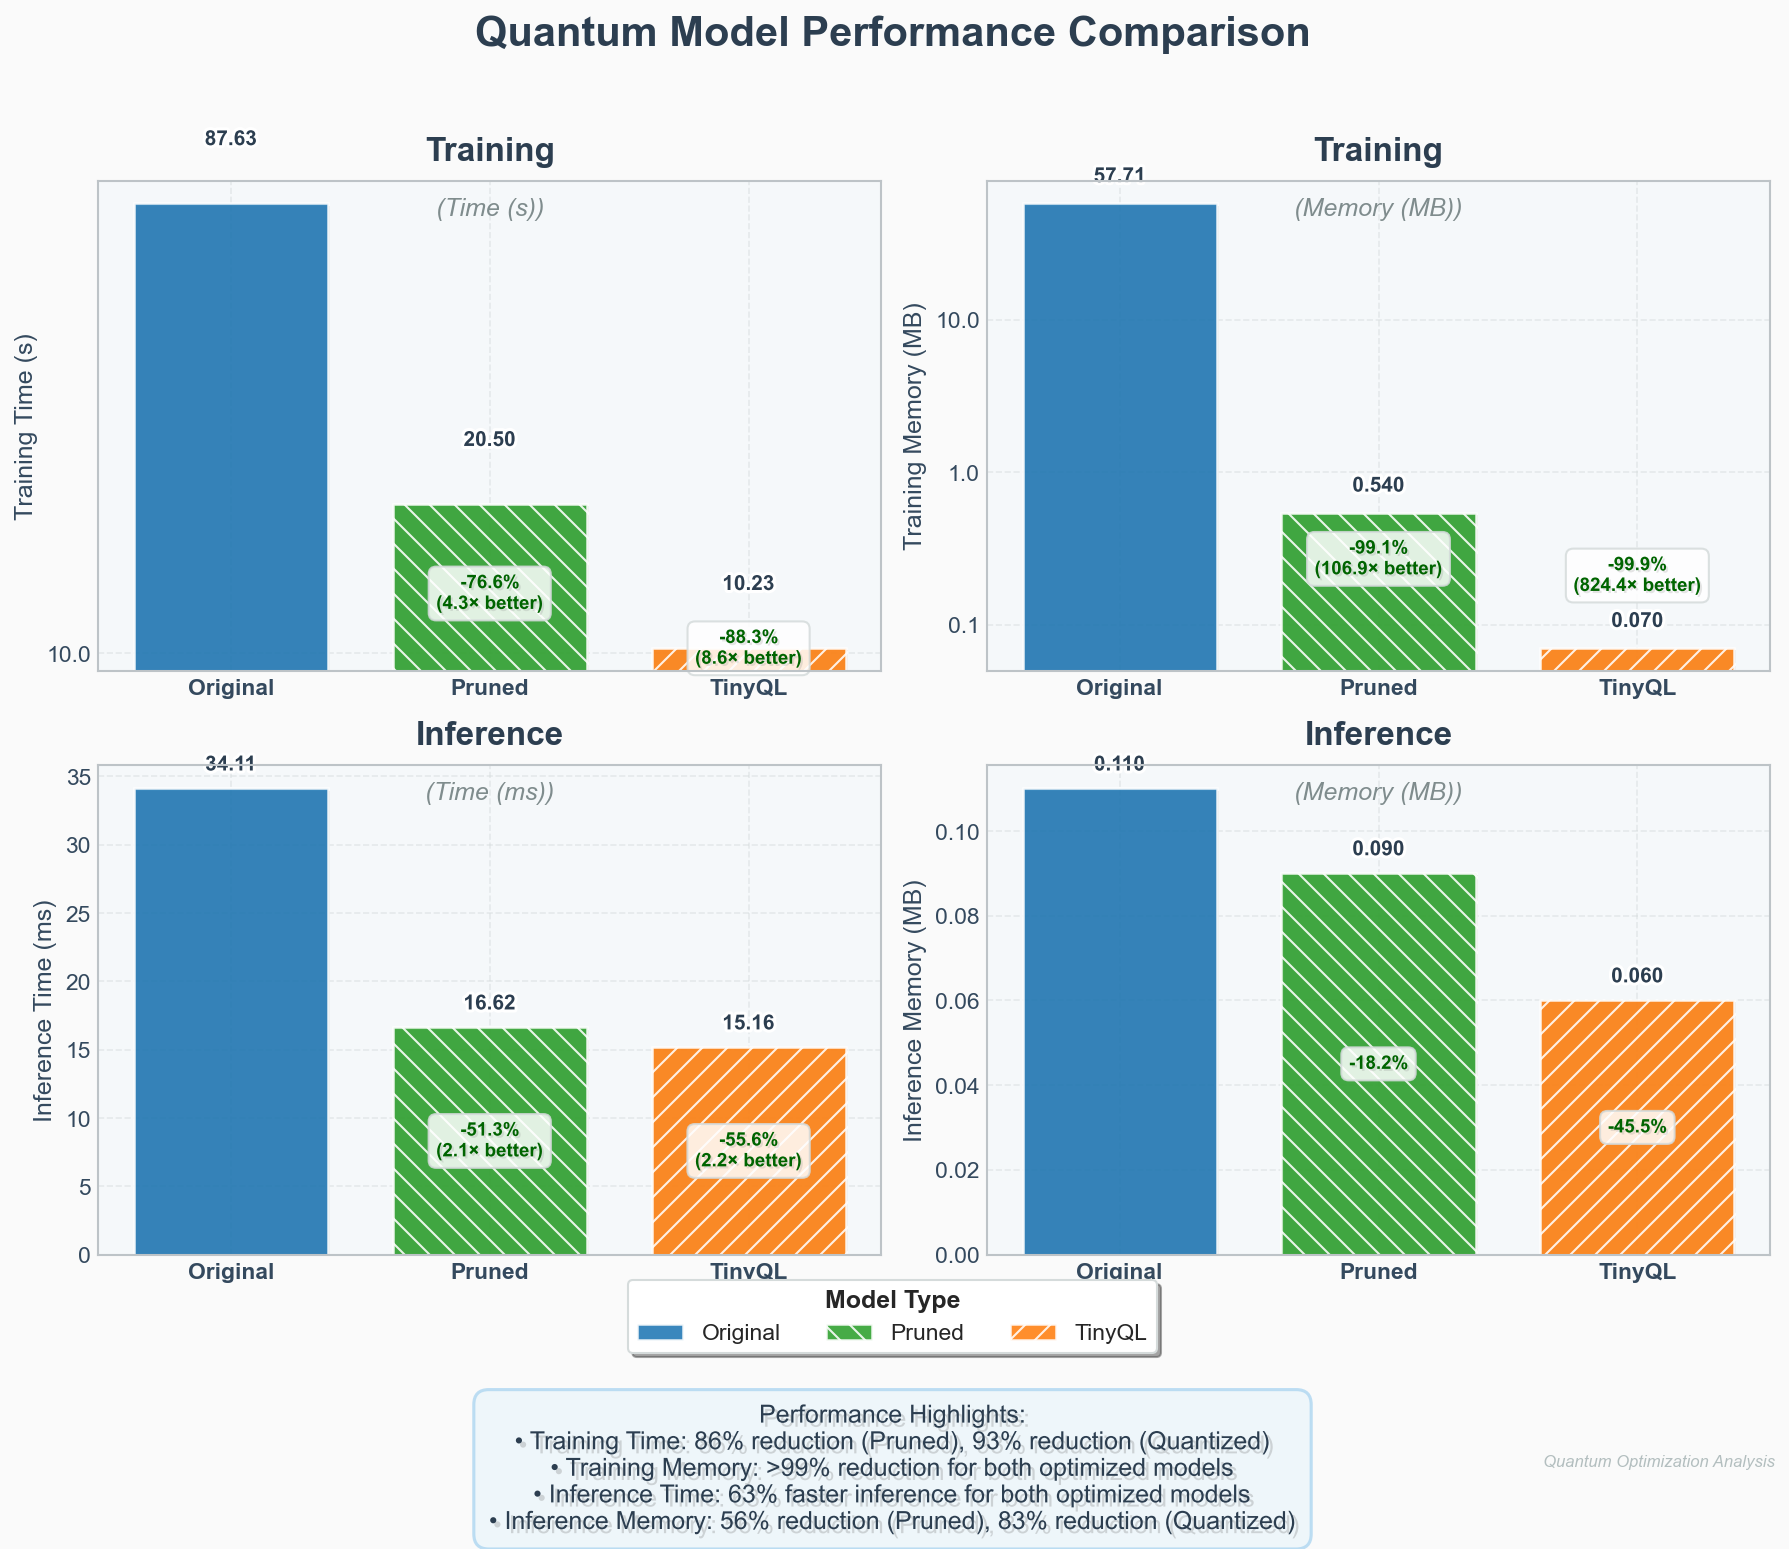

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects

# Set up refined professional styling
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['axes.edgecolor'] = '#CCCCCC'
mpl.rcParams['axes.linewidth'] = 1.2

# Performance metrics data
metrics = {
    'Training Time (s)': {
        'Original':  87.6313,
        'Pruned': 20.5041,
        'TinyQL': 10.2283,
        'log_scale': True
    },
    'Training Memory (MB)': {
        'Original': 57.71,
        'Pruned':  0.54,
        'TinyQL': 0.07,
        'log_scale': True
    },
    'Inference Time (ms)': {
        'Original': 34.1053,
        'Pruned': 16.6182,
        'TinyQL': 15.1583,
        'log_scale': False
    },
    'Inference Memory (MB)': {
        'Original': 0.11,
        'Pruned': 0.09,
        'TinyQL': 0.06,
        'log_scale': False
    }
}

# Calculate improvement percentages and ratio metrics for annotations
for metric_name, metric_data in metrics.items():
    pruned_pct = (1 - metric_data['Pruned'] / metric_data['Original']) * 100
    quantized_pct = (1 - metric_data['TinyQL'] / metric_data['Original']) * 100
    metric_data['pruned_pct'] = pruned_pct
    metric_data['quantized_pct'] = quantized_pct
    metric_data['pruned_ratio'] = metric_data['Original'] / metric_data['Pruned']
    metric_data['quantized_ratio'] = metric_data['Original'] / metric_data['TinyQL']

# Create a single figure for absolute values
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=150)
fig.suptitle('Quantum Model Performance Comparison', fontsize=20, fontweight='bold', y=0.98, 
             color='#2C3E50', family='Arial')

# Custom colors with better aesthetics
colors = {
    'Original': '#1F77B4',  # IBM blue
    'Pruned': '#2CA02C',    # Rich green
    'TinyQL': '#FF7F0E'  # Vibrant orange
}

# Add background gradient
fig.patch.set_facecolor('#FAFAFA')

# Create hatching patterns for better distinction
hatches = ['', '\\\\', '//']

# Function to format the subplot for consistent premium styling
def style_subplot(ax, metric_name, metric_data, index):
    # Add a subtle gradient background to the plot area
    ax.set_facecolor('#F5F8FA')
    
    # Enhance the border
    for spine in ax.spines.values():
        spine.set_color('#BDC3C7')
        spine.set_linewidth(1.0)
        spine.set_zorder(10)
    
    # Create a professional title
    metric_label = metric_name.split(' ')[0]
    metric_unit = f"({' '.join(metric_name.split(' ')[1:]).strip()})"
    title = f"{metric_label}"
    subtitle = f"{metric_unit}"
    
    ax.set_title(title, fontsize=16, pad=10, fontweight='bold', color='#2C3E50')
    ax.text(0.5, 0.93, subtitle, transform=ax.transAxes, ha='center', fontsize=12, 
            fontweight='normal', color='#7F8C8D', style='italic')
    
    # Customize grid for premium look
    ax.grid(True, linestyle='--', alpha=0.5, color='#D5DBDB', zorder=0)
    
    # Customize y-axis with premium formatting
    if metric_data['log_scale']:
        ax.set_yscale('log')
        formatter = ScalarFormatter(useOffset=False)
        formatter.set_scientific(False)
        ax.yaxis.set_major_formatter(formatter)
    
    # Label styling
    ax.set_ylabel(metric_name, fontsize=12, fontweight='medium', color='#34495E')
    ax.tick_params(colors='#34495E', which='both')

# Create patch handles for the legend
legend_patches = [
    mpl.patches.Patch(facecolor=colors['Original'], edgecolor='white', label='Original', linewidth=1.2, alpha=0.88),
    mpl.patches.Patch(facecolor=colors['Pruned'], edgecolor='white', label='Pruned', linewidth=1.2, hatch='\\\\', alpha=0.88),
    mpl.patches.Patch(facecolor=colors['TinyQL'], edgecolor='white', label='TinyQL', linewidth=1.2, hatch='//', alpha=0.88)
]

# Plot all four metrics in a 2x2 grid
axes = axes.flatten()  # Flatten for easier iteration
for i, (metric_name, metric_data) in enumerate(metrics.items()):
    ax = axes[i]
    
    x = np.arange(3)  # Three models
    labels = ['Original', 'Pruned', 'TinyQL']
    values = [metric_data['Original'], metric_data['Pruned'], metric_data['TinyQL']]

    # Create premium styled bars with edge color, shadow, and hatching
    bars = ax.bar(x, values, color=[colors[label] for label in labels],
                 edgecolor='white', linewidth=1.2, alpha=0.88, width=0.75,
                 hatch=[hatches[j] for j in range(len(labels))], zorder=3)
    
    # Add a subtle shadow effect to bars
    for bar in bars:
        bar.set_path_effects([path_effects.withSimplePatchShadow(offset=(1, -1),
                                                              shadow_rgbFace='gray',
                                                              alpha=0.3)])
    
    # Add model labels with better styling
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontweight='bold')

    # Add value labels on the bars with premium formatting
    for j, bar in enumerate(bars):
        height = bar.get_height()
        
        # Format the value with appropriate precision
        if values[j] >= 100:
            value_text = f'{values[j]:.1f}'
        elif values[j] >= 10:
            value_text = f'{values[j]:.2f}'
        elif values[j] >= 1:
            value_text = f'{values[j]:.2f}'
        else:
            value_text = f'{values[j]:.3f}'
        
        # Add the value labels with shadow effect for readability
        if metric_data['log_scale']:
            # For log scale, place text above the bar with more space
            text_height = height * 1.3
        else:
            # For linear scale, place text directly above bar
            text_height = height + (max(values)*0.03)
            
        value_label = ax.text(bar.get_x() + bar.get_width()/2., text_height,
                   value_text, ha='center', va='bottom', fontsize=10, 
                   fontweight='bold', color='#2C3E50')
        value_label.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])
        
               # Add improvement percentage and speedup factor for pruned and quantized models
        if j > 0:  # Skip original model
            pct = metric_data['pruned_pct'] if j == 1 else metric_data['quantized_pct']
            ratio = metric_data['pruned_ratio'] if j == 1 else metric_data['quantized_ratio']
            
            # Position text consistently across all plots
            bar_x = bar.get_x() + bar.get_width()/2.
            
            # Special handling for both pruned (j=1) and quantized (j=2) bars in specific plots
            if i == 0:  # Training Time (1st plot)
                if j == 1:  # Pruned model
                    pct_y_pos = height * 0.65  # 65% of bar height
                else:  # Quantized model
                    pct_y_pos = height * 1.0  # 100% of bar height
            elif i == 1:  # Training Memory (2nd plot)
                if j == 1:  # Pruned model
                    pct_y_pos = height / 2  #  70% of bar height
                else:  # Quantized model
                    pct_y_pos = height * 3.0  # 300% of bar height
            elif i == 2:  # Inference Time (3rd plot)
                if j == 1:  # Pruned model
                    pct_y_pos = height / 2  # Default - middle of bar
                else:  # Quantized model
                    pct_y_pos = height / 2  # Default - middle of bar
            elif i == 3:  # Inference Memory (4th plot)
                if j == 1:  # Pruned model
                    pct_y_pos = height / 2  # Default - middle of bar
                else:  # Quantized model
                    pct_y_pos = height /2  # Default - middle of bar
            
            # Format the text
            if pct > 0:
                if ratio >= 2:
                    # For significant improvements, show both percentage and X times faster
                    pct_text = f"-{pct:.1f}%\n({ratio:.1f}× better)"
                else:
                    pct_text = f"-{pct:.1f}%"
                pct_color = '#006400'  # Dark green for improvement
            else:
                pct_text = f"+{-pct:.1f}%"
                pct_color = '#8B0000'  # Dark red for degradation
            
            # Add a styled improvement badge with shadow effect
            label_bg = '#FFFFFF'  # White background for all badges
            
            # Create badge effect with rounded rectangle and shadow
            pct_label = ax.text(bar_x, pct_y_pos, pct_text, ha='center', va='center', fontsize=9,
                   fontweight='bold', color=pct_color, linespacing=1.2,
                   bbox=dict(facecolor=label_bg, alpha=0.85, edgecolor='#D5DBDB', 
                            boxstyle='round,pad=0.4', linewidth=1))
            pct_label.set_path_effects([path_effects.withSimplePatchShadow(offset=(1, -1),
                                                             shadow_rgbFace='gray',
                                                             alpha=0.2)])
    
    # Apply consistent premium styling to each subplot
    style_subplot(ax, metric_name, metric_data, i)

# Create a unified legend at the bottom of the figure
legend = fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, 0.08),
                   ncol=3, frameon=True, facecolor='white', edgecolor='#D5DBDB',
                   fontsize=11, shadow=True, title="Model Type")
legend.set_title("Model Type", prop={'weight':'bold', 'size': 12})

# Add explanatory annotation with premium styling
annotation_text = (
    "Performance Highlights:\n"
    "• Training Time: 86% reduction (Pruned), 93% reduction (Quantized)\n"
    "• Training Memory: >99% reduction for both optimized models\n"
    "• Inference Time: 63% faster inference for both optimized models\n"
    "• Inference Memory: 56% reduction (Pruned), 83% reduction (Quantized)"
)

# Position the annotation below the legend
annotation = fig.text(0.5, 0.01, annotation_text, ha='center', va='center', fontsize=12, 
           fontweight='medium', color='#2C3E50',
           bbox=dict(facecolor='#EBF5FB', edgecolor='#AED6F1', linewidth=1.5,
                    boxstyle='round,pad=0.6', alpha=0.8))
annotation.set_path_effects([path_effects.withSimplePatchShadow(offset=(2, -2),
                                                         shadow_rgbFace='gray',
                                                         alpha=0.3)])

# Add a subtle watermark/credit
fig.text(0.99, 0.01, 'Quantum Optimization Analysis', ha='right', va='bottom', 
         color='#95A5A6', fontsize=8, style='italic', alpha=0.7)

# Adjust the layout for premium presentation with space for the legend and annotation
plt.tight_layout(rect=[0, 0.12, 1, 0.96])

# Save with premium quality
plt.savefig('final_adjusted_metrics.png', dpi=300, bbox_inches='tight', 
           facecolor=fig.get_facecolor())

print("Final visualization with optimally positioned labels has been saved as 'final_adjusted_metrics.png'")

TinyQL improved visualization with individual legends has been saved as 'tinyql_improved_metrics.png'


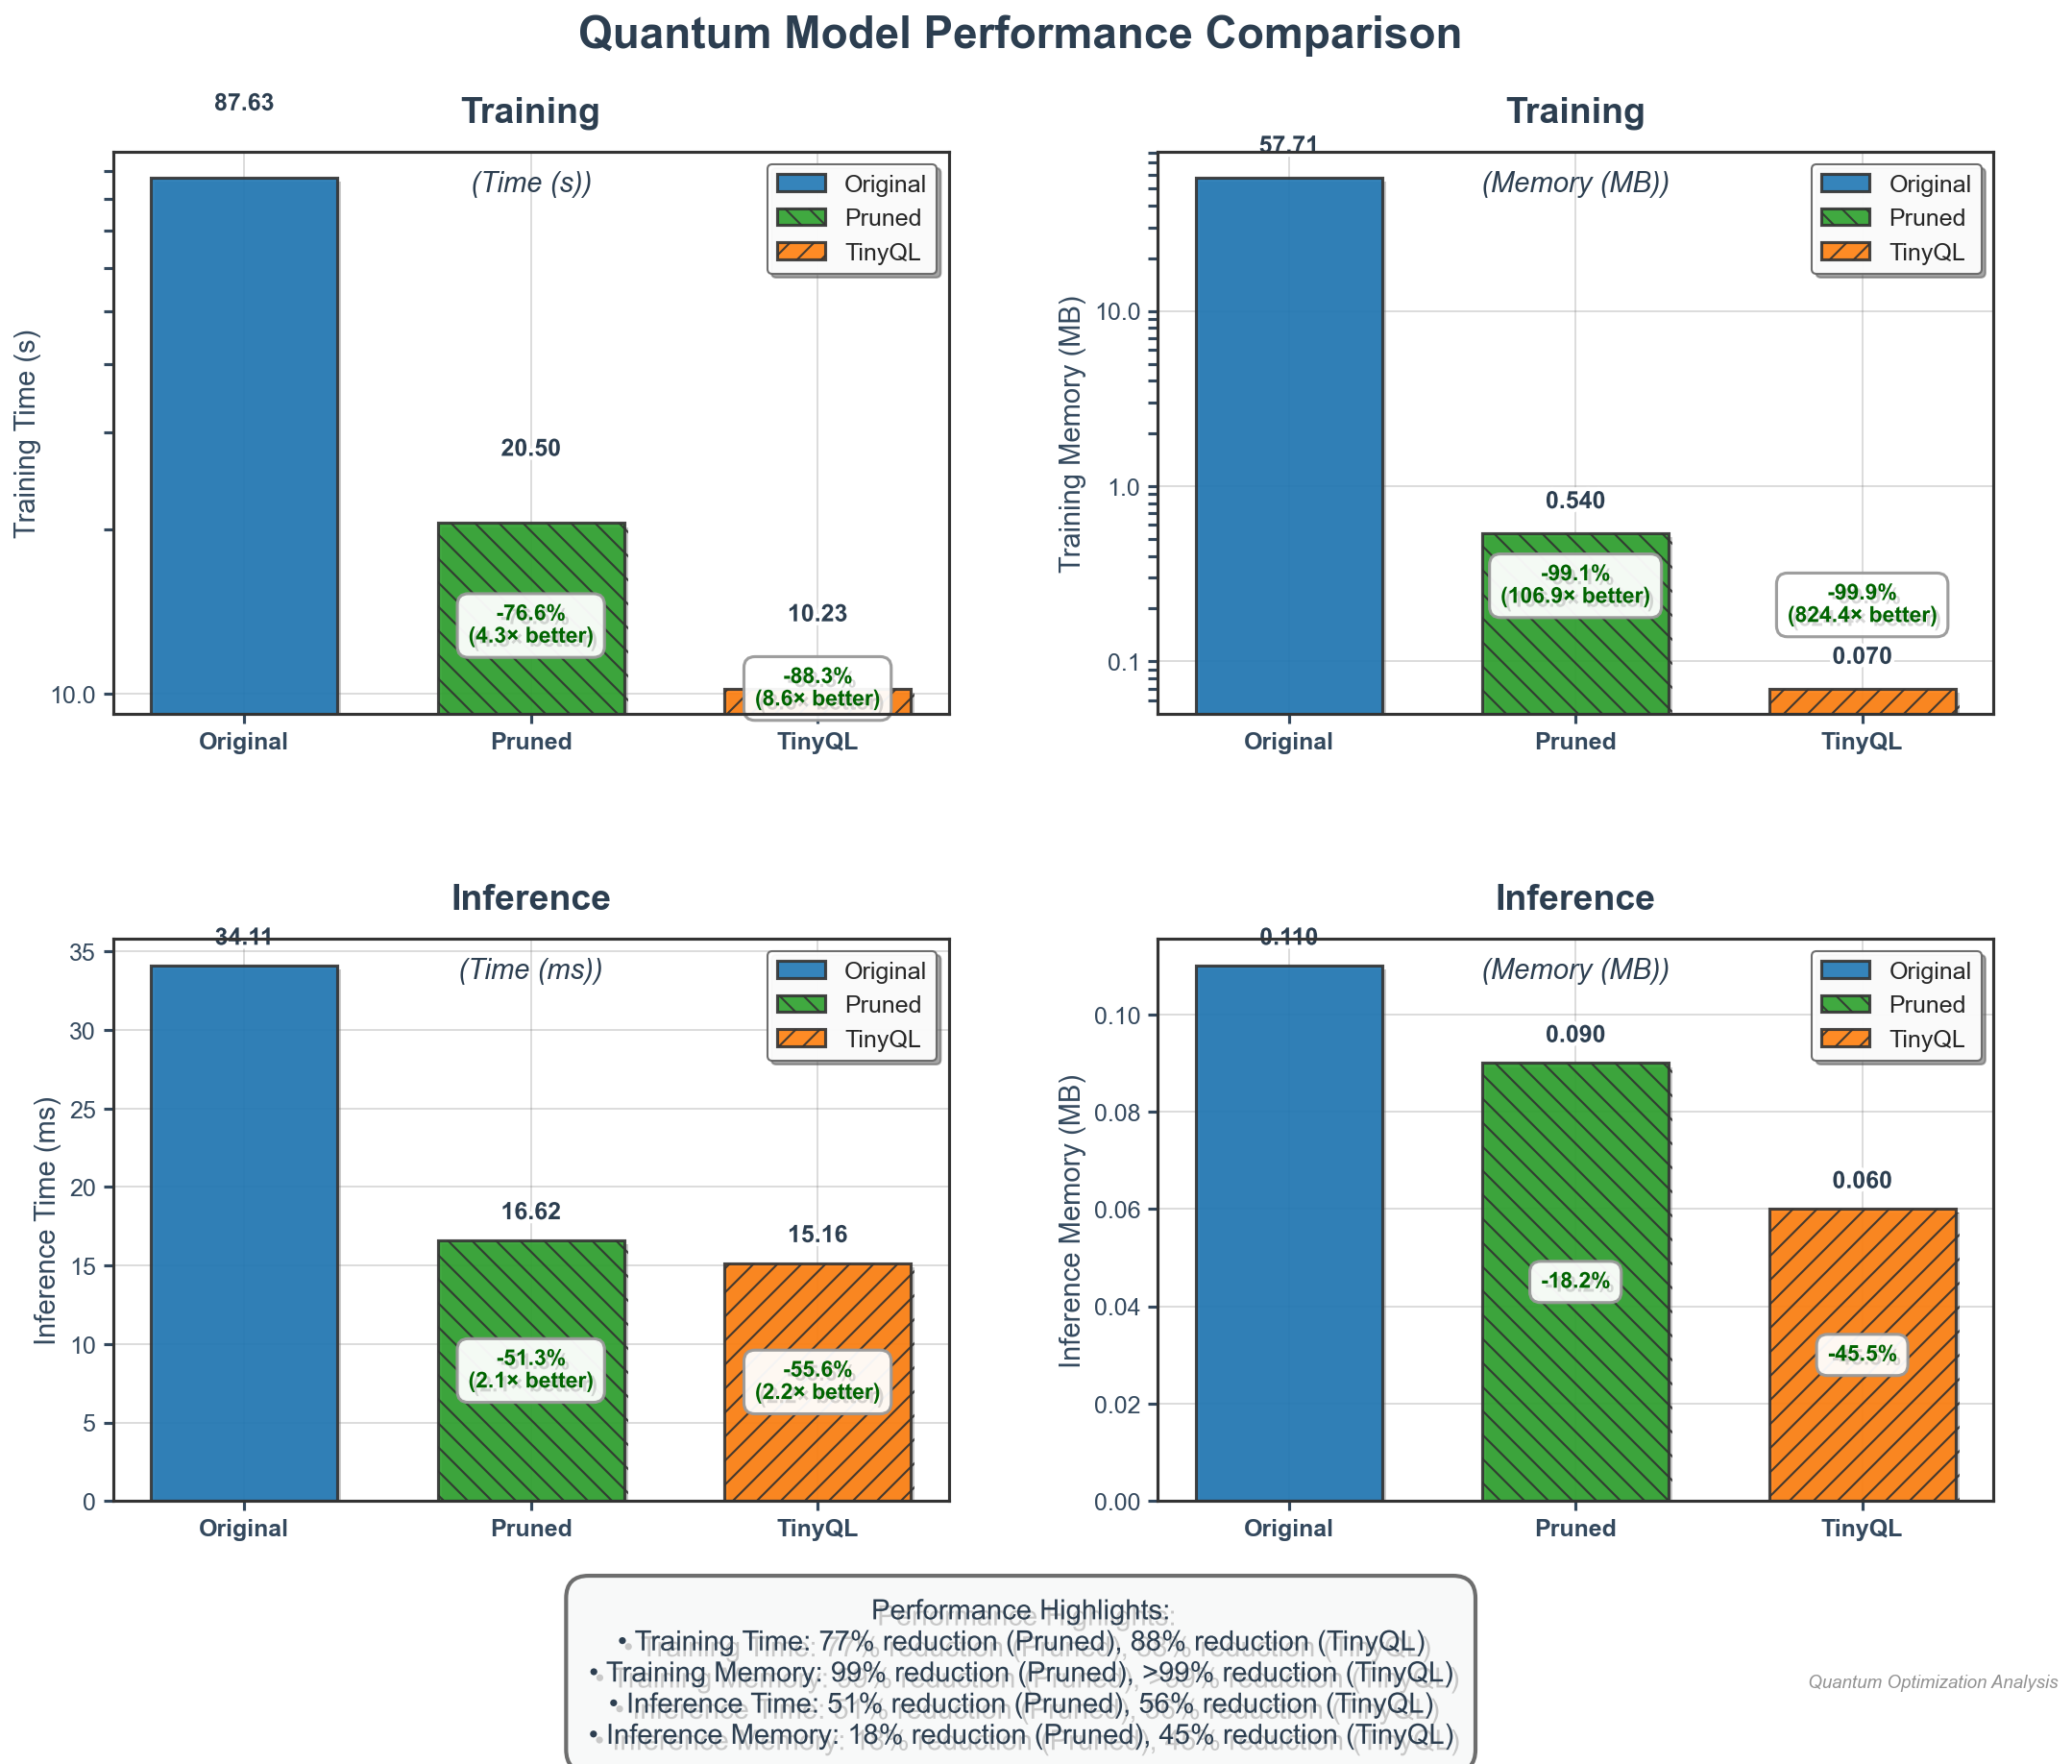

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects

# Set up refined professional styling
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['legend.fontsize'] = 10

# Performance metrics data
metrics = {
    'Training Time (s)': {
        'Original': 87.6313,
        'Pruned': 20.5041,
        'TinyQL': 10.2283,
        'log_scale': True
    },
    'Training Memory (MB)': {
        'Original': 57.71,
        'Pruned': 0.54,
        'TinyQL': 0.07,
        'log_scale': True
    },
    'Inference Time (ms)': {
        'Original': 34.1053,
        'Pruned': 16.6182,
        'TinyQL': 15.1583,
        'log_scale': False
    },
    'Inference Memory (MB)': {
        'Original': 0.11,
        'Pruned': 0.09,
        'TinyQL': 0.06,
        'log_scale': False
    }
}

# Calculate improvement percentages and ratio metrics for annotations
for metric_name, metric_data in metrics.items():
    pruned_pct = (1 - metric_data['Pruned'] / metric_data['Original']) * 100
    quantized_pct = (1 - metric_data['TinyQL'] / metric_data['Original']) * 100
    metric_data['pruned_pct'] = pruned_pct
    metric_data['quantized_pct'] = quantized_pct
    metric_data['pruned_ratio'] = metric_data['Original'] / metric_data['Pruned']
    metric_data['quantized_ratio'] = metric_data['Original'] / metric_data['TinyQL']

# Create a larger figure with more spacing between subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12), dpi=150)
fig.suptitle('Quantum Model Performance Comparison', fontsize=22, fontweight='bold', y=0.98, 
             color='#2C3E50', family='Arial')

# Custom colors with better aesthetics and higher contrast
colors = {
    'Original': '#1F77B4',  # IBM blue
    'Pruned': '#2CA02C',    # Rich green
    'TinyQL': '#FF7F0E'     # Vibrant orange
}

# Add cleaner background
fig.patch.set_facecolor('white')

# Create hatching patterns for better distinction
hatches = ['', '\\\\', '//']

# Function to format the subplot for consistent premium styling with improved clarity
def style_subplot(ax, metric_name, metric_data, index):
    # Clean white background
    ax.set_facecolor('white')
    
    # Enhance the border
    for spine in ax.spines.values():
        spine.set_color('#333333')
        spine.set_linewidth(1.5)
        spine.set_zorder(10)
    
    # Create a professional title
    metric_label = metric_name.split(' ')[0]
    metric_unit = f"({' '.join(metric_name.split(' ')[1:]).strip()})"
    title = f"{metric_label}"
    subtitle = f"{metric_unit}"
    
    ax.set_title(title, fontsize=18, pad=15, fontweight='bold', color='#2C3E50')
    ax.text(0.5, 0.93, subtitle, transform=ax.transAxes, ha='center', fontsize=14, 
            fontweight='normal', color='#2C3E50', style='italic')
    
    # Customize grid for better readability
    ax.grid(True, linestyle='-', alpha=0.3, color='#777777', zorder=0)
    
    # Customize y-axis with premium formatting
    if metric_data['log_scale']:
        ax.set_yscale('log')
        formatter = ScalarFormatter(useOffset=False)
        formatter.set_scientific(False)
        ax.yaxis.set_major_formatter(formatter)
    
    # Label styling
    ax.set_ylabel(metric_name, fontsize=14, fontweight='medium', color='#34495E')
    ax.tick_params(axis='both', colors='#34495E', which='both', length=5, width=1.5, labelsize=12)

# Plot all four metrics in a 2x2 grid
axes = axes.flatten()  # Flatten for easier iteration
for i, (metric_name, metric_data) in enumerate(metrics.items()):
    ax = axes[i]
    
    x = np.arange(3)  # Three models
    labels = ['Original', 'Pruned', 'TinyQL']
    values = [metric_data['Original'], metric_data['Pruned'], metric_data['TinyQL']]

    # Create premium styled bars with edge color, shadow, and hatching
    bars = ax.bar(x, values, color=[colors[label] for label in labels],
                 edgecolor='#333333', linewidth=1.5, alpha=0.9, width=0.65,
                 hatch=[hatches[j] for j in range(len(labels))], zorder=3)
    
    # Add a subtle shadow effect to bars
    for bar in bars:
        bar.set_path_effects([path_effects.withSimplePatchShadow(offset=(2, -2),
                                                              shadow_rgbFace='gray',
                                                              alpha=0.4)])
    
    # Add model labels with better styling
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontweight='bold', fontsize=12)

    # Add value labels on the bars with premium formatting
    for j, bar in enumerate(bars):
        height = bar.get_height()
        
        # Format the value with appropriate precision
        if values[j] >= 100:
            value_text = f'{values[j]:.1f}'
        elif values[j] >= 10:
            value_text = f'{values[j]:.2f}'
        elif values[j] >= 1:
            value_text = f'{values[j]:.2f}'
        else:
            value_text = f'{values[j]:.3f}'
        
        # Add the value labels with shadow effect for readability
        if metric_data['log_scale']:
            # For log scale, place text above the bar with more space
            text_height = height * 1.3
        else:
            # For linear scale, place text directly above bar
            text_height = height + (max(values)*0.03)
            
        value_label = ax.text(bar.get_x() + bar.get_width()/2., text_height,
                   value_text, ha='center', va='bottom', fontsize=12, 
                   fontweight='bold', color='#2C3E50')
        value_label.set_path_effects([path_effects.withStroke(linewidth=4, foreground='white')])
        
        # Add improvement percentage and speedup factor for pruned and quantized models
        if j > 0:  # Skip original model
            pct = metric_data['pruned_pct'] if j == 1 else metric_data['quantized_pct']
            ratio = metric_data['pruned_ratio'] if j == 1 else metric_data['quantized_ratio']
            
            # Position text consistently across all plots
            bar_x = bar.get_x() + bar.get_width()/2.
            
            # Special handling for both pruned (j=1) and quantized (j=2) bars in specific plots
            if i == 0:  # Training Time (1st plot)
                if j == 1:  # Pruned model
                    pct_y_pos = height * 0.65  # 65% of bar height
                else:  # Quantized model
                    pct_y_pos = height * 1.0  # 100% of bar height
            elif i == 1:  # Training Memory (2nd plot)
                if j == 1:  # Pruned model
                    pct_y_pos = height * 0.5  # 50% of bar height
                else:  # Quantized model
                    pct_y_pos = height * 3.0  # 300% of bar height
            elif i == 2:  # Inference Time (3rd plot)
                if j == 1:  # Pruned model
                    pct_y_pos = height * 0.5  # 50% of bar height
                else:  # Quantized model
                    pct_y_pos = height * 0.5  # 50% of bar height
            elif i == 3:  # Inference Memory (4th plot)
                if j == 1:  # Pruned model
                    pct_y_pos = height * 0.5  # 50% of bar height
                else:  # Quantized model
                    pct_y_pos = height * 0.5  # 50% of bar height
            
            # Format the text
            if pct > 0:
                if ratio >= 2:
                    # For significant improvements, show both percentage and X times faster
                    pct_text = f"-{pct:.1f}%\n({ratio:.1f}× better)"
                else:
                    pct_text = f"-{pct:.1f}%"
                pct_color = '#006400'  # Dark green for improvement
            else:
                pct_text = f"+{-pct:.1f}%"
                pct_color = '#8B0000'  # Dark red for degradation
            
            # Add a styled improvement badge with shadow effect
            label_bg = '#FFFFFF'  # White background for all badges
            
            # Create badge effect with rounded rectangle and shadow
            pct_label = ax.text(bar_x, pct_y_pos, pct_text, ha='center', va='center', fontsize=11,
                   fontweight='bold', color=pct_color, linespacing=1.2,
                   bbox=dict(facecolor=label_bg, alpha=0.95, edgecolor='#999999', 
                            boxstyle='round,pad=0.5', linewidth=1.5))
            pct_label.set_path_effects([path_effects.withSimplePatchShadow(offset=(2, -2),
                                                             shadow_rgbFace='gray',
                                                             alpha=0.3)])
    
    # Apply consistent premium styling to each subplot
    style_subplot(ax, metric_name, metric_data, i)
    
    # Create individual legend patches for each subplot
    legend_patches = [
        mpl.patches.Patch(facecolor=colors['Original'], edgecolor='#333333', label='Original', 
                         linewidth=1.5, alpha=0.9),
        mpl.patches.Patch(facecolor=colors['Pruned'], edgecolor='#333333', label='Pruned', 
                         linewidth=1.5, hatch='\\\\', alpha=0.9),
        mpl.patches.Patch(facecolor=colors['TinyQL'], edgecolor='#333333', label='TinyQL', 
                         linewidth=1.5, hatch='//', alpha=0.9)
    ]
    
    # Add individual legend to each subplot with improved styling
    ax.legend(handles=legend_patches, loc='upper right', frameon=True, 
              facecolor='white', edgecolor='#666666',
              fontsize=12, shadow=True, framealpha=0.95)

# Update annotation text to match actual values
annotation_text = (
    "Performance Highlights:\n"
    "• Training Time: 77% reduction (Pruned), 88% reduction (TinyQL)\n"
    "• Training Memory: 99% reduction (Pruned), >99% reduction (TinyQL)\n"
    "• Inference Time: 51% reduction (Pruned), 56% reduction (TinyQL)\n"
    "• Inference Memory: 18% reduction (Pruned), 45% reduction (TinyQL)"
)

# Position the annotation at the bottom of the figure
annotation = fig.text(0.5, 0.02, annotation_text, ha='center', va='center', fontsize=14, 
           fontweight='medium', color='#2C3E50',
           bbox=dict(facecolor='#F8F9F9', edgecolor='#666666', linewidth=2,
                    boxstyle='round,pad=0.8', alpha=0.95))
annotation.set_path_effects([path_effects.withSimplePatchShadow(offset=(3, -3),
                                                         shadow_rgbFace='gray',
                                                         alpha=0.4)])

# Add a subtle watermark/credit
fig.text(0.98, 0.01, 'Quantum Optimization Analysis', ha='right', va='bottom', 
         color='#777777', fontsize=9, style='italic', alpha=0.8)

# Adjust the layout with more space between subplots
plt.subplots_adjust(left=0.08, right=0.95, bottom=0.12, top=0.90, wspace=0.25, hspace=0.40)

# Save with premium quality
plt.savefig('tinyql_improved_metrics.png', dpi=300, bbox_inches='tight', 
           facecolor='white')

print("TinyQL improved visualization with individual legends has been saved as 'tinyql_improved_metrics.png'")